# Проект Телеком

Оператор связи «ТелеДом» хочет бороться с оттоком клиентов. Для этого его сотрудники начнут предлагать промокоды и специальные условия всем, кто планирует отказаться от услуг связи.

Чтобы заранее находить таких пользователей, «ТелеДому» нужна модель, которая будет предсказывать, разорвёт ли абонент договор. Команда оператора собрала персональные данные о некоторых клиентах, информацию об их тарифах и услугах.

Задача — обучить на этих данных модель для прогноза оттока клиентов.

## Описание услуг

Оператор предоставляет два основных типа услуг:

- Стационарную телефонную связь. Телефон можно подключить к нескольким линиям одновременно.
- Интернет. Подключение бывает двух типов: через телефонную линию DSL (англ. digital subscriber line — «цифровая абонентская линия») или оптоволоконный кабель (англ. fiber optic).

Также абонентам доступен ряд услуг:

- Интернет-безопасность: антивирус (Device Protection) и блокировка опасных сайтов (Online Security);
- Выделенная линия технической поддержки (Tech Support);
- Облачное хранилище файлов для резервного копирования данных (Online Backup);
- Стриминговое телевидение (Streaming TV) и каталог фильмов (Streaming Movies).

За услуги клиенты могут платить ежемесячно или раз в 1–2 года. Доступны различные способы расчёта и возможность получить электронный чек.

## Описание данных

Данные хранятся в базе данных PostgreSQL. Она состоит из нескольких таблиц:
    
- `contract` — информация о договорах;
- `personal` — персональные данные клиентов;
- `internet` — информация об интернет-услугах;
- `phone` — информация об услугах телефонии.

Таблица `telecom.contract`

- `customerID` — ID абонента;
- `BeginDate` — дата начала действия договора;
- `EndDate` — дата окончания действия договора;
- `Type` — тип оплаты: раз в год-два или ежемесячно;
- `PaperlessBilling` — электронный расчётный лист;
- `PaymentMethod` — тип платежа;
- `MonthlyCharges` — расходы за месяц;
- `TotalCharges` — общие расходы абонента.


Таблица `personal`

- `customerID` — ID пользователя;
- `gender` — пол;
- `SeniorCitizen` — является ли абонент пенсионером;
- `Partner` — есть ли у абонента супруг или супруга;
- `Dependents` — есть ли у абонента дети.

Таблица `telecom.internet`

- `customerID` — ID пользователя;
- `InternetService` — тип подключения;
- `OnlineSecurity` — блокировка опасных сайтов;
- `OnlineBackup` — облачное хранилище файлов для резервного копирования данных;
- `DeviceProtection` — антивирус;
- `TechSupport` — выделенная линия технической поддержки;
- `StreamingTV` — стриминговое телевидение;
- `StreamingMovies` — каталог фильмов.

Таблица `telecom.phone`

- `customerID` — ID пользователя;
- `MultipleLines` — подключение телефона к нескольким линиям одновременно

Информация о договорах актуальна на 1 февраля 2020.

# Установка окружения, импорт библиотек

In [1]:
# conda install -c conda-forge shap

In [2]:
!pip install shap --use-deprecated=legacy-resolver

DEPRECATION: colab 1.13.5 has a non-standard dependency specifier pytz>=2011n. pip 24.1 will enforce this behaviour change. A possible replacement is to upgrade to a newer version of colab or contact the author to suggest that they release a version with a conforming dependency specifiers. Discussion can be found at https://github.com/pypa/pip/issues/12063


In [3]:
!pip install -q phik

DEPRECATION: colab 1.13.5 has a non-standard dependency specifier pytz>=2011n. pip 24.1 will enforce this behaviour change. A possible replacement is to upgrade to a newer version of colab or contact the author to suggest that they release a version with a conforming dependency specifiers. Discussion can be found at https://github.com/pypa/pip/issues/12063


In [4]:
import warnings
warnings.filterwarnings('ignore')

In [5]:
import shap

In [6]:
import phik
from phik.report import plot_correlation_matrix

In [7]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib import pyplot as plt


import random

import torch
import torch.nn as nn
import copy

from math import ceil



from sklearn.model_selection import(
    train_test_split,
    GridSearchCV,
    cross_val_score,
    StratifiedKFold
)
from sklearn.preprocessing import(
    OrdinalEncoder,
    StandardScaler
)

from sklearn.metrics import(
    roc_curve,
    confusion_matrix,
    precision_recall_curve,
    roc_auc_score,
    accuracy_score
)

from sklearn.tree import DecisionTreeClassifier
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier


from sklearn.ensemble import RandomForestClassifier

from sklearn.linear_model import LogisticRegression

from sklearn.dummy import DummyClassifier


from sqlalchemy import create_engine, text

In [8]:
from pandas.api.types import is_numeric_dtype

Фиксируем random_state:

In [9]:
random_state=80524

Подключение к базе данных:

In [10]:
db_config = {
'user': 'praktikum_student',
'pwd': 'Sdf4$2;d-d30pp',
'host': 'rc1b-wcoijxj3yxfsf3fs.mdb.yandexcloud.net',
'port': 6432,
'db': 'data-science-final'
}

In [11]:
connection_string = 'postgresql://{}:{}@{}:{}/{}'.format(
    db_config['user'],
    db_config['pwd'],
    db_config['host'],
    db_config['port'],
    db_config['db'],
)

In [12]:
engine = create_engine(connection_string)

# Изучение данных. Предобработка.

Функция для вывода информации о таблице:

In [13]:
def describe_table(table):

    table.info()
    print()
    display(table.sample(5))


    L_numeric = []
    L_object = []

    for col in table.columns:
        if is_numeric_dtype(table[col]):
            L_numeric.append(col)
        else:
            L_object.append(col)

    if len(L_numeric) > 0:
        print('Numeric Describe:')
        display(table[L_numeric].describe());

    if len(L_object) > 0:
        print('Object Describe:')
        display(table[L_object].describe());

    if len(L_numeric) > 0:
        print()
        table[L_numeric].hist(figsize=(10, 5));

Функция, выводящая гистограмму для числового поля:

In [14]:
def numeric_hist(data, line, x_title, y_title, title, bins):
    fig, ax = plt.subplots()
    ax = data[line].plot.hist(bins=bins, range=(0, 150), title=title);

    ax.set(xlabel = x_title,
           ylabel = y_title)

    fig.set_facecolor('floralwhite')
    ax.set_facecolor('seashell')

    plt.show()

## Таблица `telecom.contract`

customerID — ID абонента;

BeginDate — дата начала действия договора;

EndDate — дата окончания действия договора;

Type — тип оплаты: раз в год-два или ежемесячно;

PaperlessBilling — электронный расчётный лист;

PaymentMethod — тип платежа;

MonthlyCharges — расходы за месяц;

TotalCharges — общие расходы абонента.

In [15]:
query = '''
SELECT *
FROM telecom.contract;
'''

In [16]:
#telecom_contract = pd.read_sql_query(query, con = engine)
telecom_contract = pd.DataFrame(engine.connect().execute(text(query)))
describe_table(telecom_contract)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 8 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   customerID        7043 non-null   object
 1   BeginDate         7043 non-null   object
 2   EndDate           1869 non-null   object
 3   Type              7043 non-null   object
 4   PaperlessBilling  7043 non-null   object
 5   PaymentMethod     7043 non-null   object
 6   MonthlyCharges    7043 non-null   object
 7   TotalCharges      7032 non-null   object
dtypes: object(8)
memory usage: 440.3+ KB



,customerID,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges
2691,4646-QZXTF,2019-03-30,None,Month-to-month,No,Bank transfer (automatic),81.25,580.1
4053,6176-YJWAS,2019-05-02,None,Two year,Yes,Credit card (automatic),97.95,7114.25
5596,7252-NTGSS,2019-05-11,None,Month-to-month,No,Mailed check,45.15,45.15
807,5692-FPTAH,2019-02-03,2020-01-01,Month-to-month,Yes,Mailed check,45.4,45.4
2042,7018-WBJNK,2018-08-08,None,Month-to-month,Yes,Credit card (automatic),78.3,1033.95


Object Describe:


,customerID,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges
count,7043,7043,1869,7043,7043,7043,7043,7032
unique,7043,515,4,3,2,4,1585,6530
top,4472-LVYGI,2019-03-24,2019-11-01,Month-to-month,Yes,Electronic check,20.05,20.2
freq,1,43,485,3875,4171,2365,61,11


In [17]:
telecom_contract.head()

,customerID,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges
0,4472-LVYGI,2020-02-01,None,Two year,Yes,Bank transfer (automatic),52.55,None
1,3115-CZMZD,2020-02-01,None,Two year,No,Mailed check,20.25,None
2,3668-QPYBK,2018-08-09,2019-12-01,Month-to-month,Yes,Mailed check,53.85,108.15
3,5709-LVOEQ,2020-02-01,None,Two year,No,Mailed check,80.85,None
4,9237-HQITU,2019-01-26,2019-11-01,Month-to-month,Yes,Electronic check,70.7,151.65


Наблюдаем большое число проупсков в столбце `EndDate`. Это может объясняться тем, что у пользователей контракт действующий.

Дубликтаов нет:

In [18]:
telecom_contract.duplicated().sum()

0

Требуется привести даты к нужному формату:

In [19]:
telecom_contract.BeginDate = pd.to_datetime(telecom_contract.BeginDate, format='%Y-%m-%d')
telecom_contract.EndDate = pd.to_datetime(telecom_contract.EndDate, format='%Y-%m-%d')
telecom_contract.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 8 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   customerID        7043 non-null   object        
 1   BeginDate         7043 non-null   datetime64[ns]
 2   EndDate           1869 non-null   datetime64[ns]
 3   Type              7043 non-null   object        
 4   PaperlessBilling  7043 non-null   object        
 5   PaymentMethod     7043 non-null   object        
 6   MonthlyCharges    7043 non-null   object        
 7   TotalCharges      7032 non-null   object        
dtypes: datetime64[ns](2), object(6)
memory usage: 440.3+ KB


Требуется привести `MonthlyCharges` и `TotalCharges` к нужному формату:

In [20]:
telecom_contract.MonthlyCharges = telecom_contract.MonthlyCharges.astype('float64')
telecom_contract.TotalCharges = telecom_contract.TotalCharges.astype('float64')
telecom_contract.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 8 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   customerID        7043 non-null   object        
 1   BeginDate         7043 non-null   datetime64[ns]
 2   EndDate           1869 non-null   datetime64[ns]
 3   Type              7043 non-null   object        
 4   PaperlessBilling  7043 non-null   object        
 5   PaymentMethod     7043 non-null   object        
 6   MonthlyCharges    7043 non-null   float64       
 7   TotalCharges      7032 non-null   float64       
dtypes: datetime64[ns](2), float64(2), object(4)
memory usage: 440.3+ KB


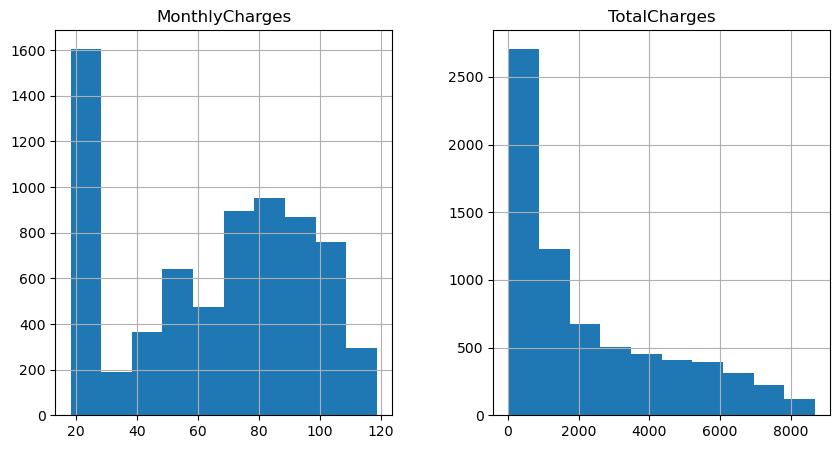

In [21]:
telecom_contract[['MonthlyCharges', 'TotalCharges']].hist(figsize=(10, 5));

Среди числовых данных аномалий не наблюдается.

Изучим категориальные столбцы:

`customerID:`

In [22]:
len(telecom_contract.customerID.unique())

7043

`Type:`

In [23]:
telecom_contract.Type.value_counts()

Month-to-month    3875
Two year          1695
One year          1473
Name: Type, dtype: int64

Большинство клиентов предпочитают платить помесячно

`PaperlessBilling:`

In [24]:
telecom_contract.PaperlessBilling.value_counts()

Yes    4171
No     2872
Name: PaperlessBilling, dtype: int64

Большинство клиентов предпочитают получать электронный чек

`PaymentMethod:`

In [25]:
telecom_contract.PaymentMethod.value_counts()

Electronic check             2365
Mailed check                 1612
Bank transfer (automatic)    1544
Credit card (automatic)      1522
Name: PaymentMethod, dtype: int64

Наиболее популярный метод оплаты -- по электронному чеку

Изучим подробнее числовые столбцы:

`MonthlyCharges:`

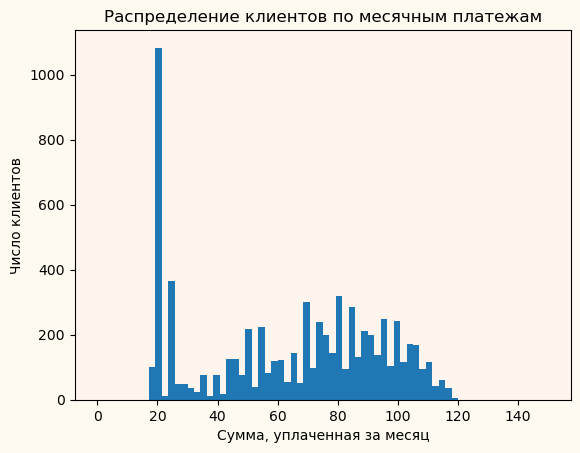

In [26]:
numeric_hist(telecom_contract, 'MonthlyCharges', 'Сумма, уплаченная за месяц',\
             'Число клиентов', 'Распределение клиентов по месячным платежам', 70)

Большинство клиентов платит немного: примерно 18-21 за месяц. Есть группа клиентов, которые предпочитают платить "среднюю" цену. Видимо, это те, кто приобретает пакеты услуг.

`TotalCharges:`

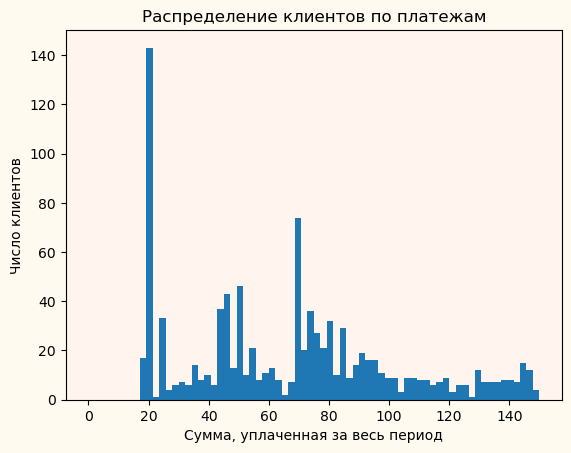

In [27]:
numeric_hist(telecom_contract, 'TotalCharges', 'Сумма, уплаченная за весь период',\
             'Число клиентов', 'Распределение клиентов по платежам', 70)

Ожидаемо, группа экономящих заплатила мало. Наблюдаем выброс в районе 70 в группе, кто платит среднюю цену. Клиентов пользующихся "премиальными" тарифами, похоже, немного: они суммарно заплатили мало. Либо же много тех, кто один или два раза воспользовался дорогостоящими услугами.

In [28]:
telecom_contract.BeginDate.sort_values().tail(15)

5256   2019-12-24
5506   2019-12-31
3649   2020-01-06
2126   2020-01-29
10     2020-02-01
7      2020-02-01
11     2020-02-01
6      2020-02-01
5160   2020-02-01
4408   2020-02-01
3      2020-02-01
1      2020-02-01
6839   2020-02-01
9      2020-02-01
0      2020-02-01
Name: BeginDate, dtype: datetime64[ns]

## Таблица `telecom.personal`

customerID — ID пользователя;

gender — пол;

SeniorCitizen — является ли абонент пенсионером;

Partner — есть ли у абонента супруг или супруга;

Dependents — есть ли у абонента дети.

In [29]:
query = '''
SELECT *
FROM telecom.personal;
'''

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 5 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   customerID     7043 non-null   object
 1   gender         7043 non-null   object
 2   SeniorCitizen  7043 non-null   int64 
 3   Partner        7043 non-null   object
 4   Dependents     7043 non-null   object
dtypes: int64(1), object(4)
memory usage: 275.2+ KB



,customerID,gender,SeniorCitizen,Partner,Dependents
3411,7056-IMHCC,Male,1,Yes,No
5449,5696-CEIQJ,Male,0,Yes,Yes
5132,3850-OKINF,Male,0,Yes,Yes
5361,2495-TTHBQ,Female,0,No,Yes
1548,5522-NYKPB,Male,0,Yes,Yes


Numeric Describe:


,SeniorCitizen
count,7043.000000
mean,0.162147
std,0.368612
min,0.000000
25%,0.000000
50%,0.000000
75%,0.000000
max,1.000000


Object Describe:


,customerID,gender,Partner,Dependents
count,7043,7043,7043,7043
unique,7043,2,2,2
top,7590-VHVEG,Male,No,No
freq,1,3555,3641,4933


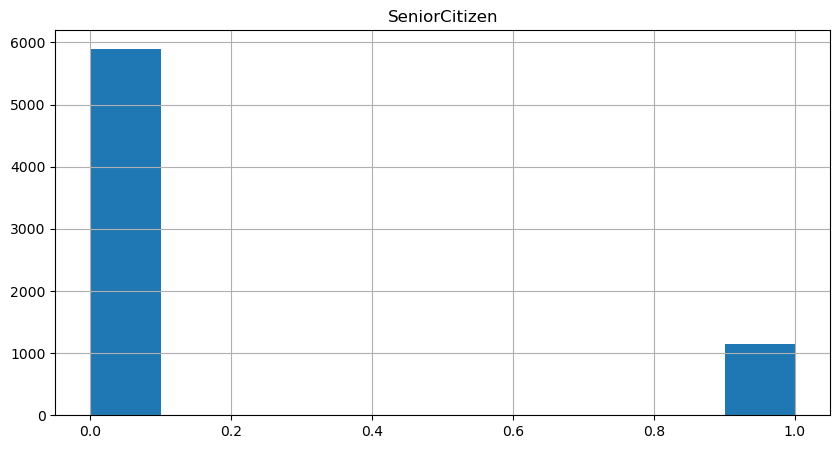

In [30]:
#telecom_personal = pd.read_sql_query(query, con = engine)
telecom_personal = pd.DataFrame(engine.connect().execute(text(query)))
describe_table(telecom_personal)

Пропусков нет

In [31]:
telecom_personal.duplicated().sum()

0

Дубликатов нет.

Изучим категориальные данные:

In [32]:
telecom_personal.gender.value_counts()

Male      3555
Female    3488
Name: gender, dtype: int64

Распределение по полам равномерное

In [33]:
telecom_personal.SeniorCitizen.value_counts()

0    5901
1    1142
Name: SeniorCitizen, dtype: int64

Пенсионеров примерно в 5 раз меньше, чем не пенсионеров.

In [34]:
telecom_personal.Partner.value_counts()

No     3641
Yes    3402
Name: Partner, dtype: int64

Примерно равное количество в браке и не в браке

In [35]:
telecom_personal.Dependents.value_counts()

No     4933
Yes    2110
Name: Dependents, dtype: int64

Бездетных чуть больше чем в 2 раза.

## Таблица `telecom.internet`


customerID — ID пользователя;

InternetService — тип подключения;

OnlineSecurity — блокировка опасных сайтов;

OnlineBackup — облачное хранилище файлов для резервного копирования данных;

DeviceProtection — антивирус;

TechSupport — выделенная линия технической поддержки;

StreamingTV — стриминговое телевидение;

StreamingMovies — каталог фильмов.

In [36]:
query = '''
SELECT *
FROM telecom.internet;
'''

In [37]:
#telecom_internet = pd.read_sql_query(query, con = engine)
telecom_internet = pd.DataFrame(engine.connect().execute(text(query)))
describe_table(telecom_internet)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5518 entries, 0 to 5517
Data columns (total 8 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   c1      5518 non-null   object
 1   c2      5518 non-null   object
 2   c3      5518 non-null   object
 3   c4      5518 non-null   object
 4   c5      5518 non-null   object
 5   c6      5518 non-null   object
 6   c7      5518 non-null   object
 7   c8      5518 non-null   object
dtypes: object(8)
memory usage: 345.0+ KB



,c1,c2,c3,c4,c5,c6,c7,c8
101,1091-SOZGA,Fiber optic,No,No,Yes,No,Yes,Yes
5150,5832-XKAES,Fiber optic,No,No,No,No,No,No
837,4026-SKKHW,DSL,No,No,No,Yes,No,No
3441,8417-FMLZI,Fiber optic,No,Yes,No,No,No,Yes
3332,5485-WUYWF,DSL,Yes,No,Yes,No,Yes,No


Object Describe:


,c1,c2,c3,c4,c5,c6,c7,c8
count,5518,5518,5518,5518,5518,5518,5518,5518
unique,5518,3,3,3,3,3,3,3
top,customerID,Fiber optic,No,No,No,No,No,No
freq,1,3096,3498,3088,3095,3473,2810,2785


Пропусков нет.

In [38]:
telecom_internet.duplicated().sum()

0

Дубликатов нет.

**В таблице не хватает примерно 2000 записей**

Исправим проблему с названиями столбцов:

In [39]:
telecom_internet.head(3)

,c1,c2,c3,c4,c5,c6,c7,c8
0,customerID,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies
1,7590-VHVEG,DSL,No,Yes,No,No,No,No
2,5575-GNVDE,DSL,Yes,No,Yes,No,No,No


In [40]:
D = {}
for i in range(0, len(telecom_internet.columns)):
    D[telecom_internet.columns[i]] = list(telecom_internet.loc[0, :])[i]
D

{'c1': 'customerID',
 'c2': 'InternetService',
 'c3': 'OnlineSecurity',
 'c4': 'OnlineBackup',
 'c5': 'DeviceProtection',
 'c6': 'TechSupport',
 'c7': 'StreamingTV',
 'c8': 'StreamingMovies'}

In [41]:
telecom_internet = telecom_internet.rename(columns=D).drop(0).reset_index(drop=True)
describe_table(telecom_internet)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5517 entries, 0 to 5516
Data columns (total 8 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   customerID        5517 non-null   object
 1   InternetService   5517 non-null   object
 2   OnlineSecurity    5517 non-null   object
 3   OnlineBackup      5517 non-null   object
 4   DeviceProtection  5517 non-null   object
 5   TechSupport       5517 non-null   object
 6   StreamingTV       5517 non-null   object
 7   StreamingMovies   5517 non-null   object
dtypes: object(8)
memory usage: 344.9+ KB



,customerID,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies
5371,4926-UMJZD,DSL,No,No,No,Yes,No,No
296,3583-KRKMD,Fiber optic,No,No,No,Yes,No,No
830,1236-WFCDV,Fiber optic,No,No,No,No,Yes,Yes
1008,4741-WWJQZ,Fiber optic,Yes,No,No,Yes,No,No
345,4360-PNRQB,Fiber optic,No,No,No,No,No,No


Object Describe:


,customerID,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies
count,5517,5517,5517,5517,5517,5517,5517,5517
unique,5517,2,2,2,2,2,2,2
top,7590-VHVEG,Fiber optic,No,No,No,No,No,No
freq,1,3096,3498,3088,3095,3473,2810,2785


In [42]:
telecom_internet.duplicated().sum()

0

Изучим категориальные столбцы:

In [43]:
telecom_internet.InternetService.value_counts()

Fiber optic    3096
DSL            2421
Name: InternetService, dtype: int64

Больше половины абонентов перешло на оптоволокно.

In [44]:
telecom_internet.OnlineSecurity.value_counts()

No     3498
Yes    2019
Name: OnlineSecurity, dtype: int64

Больше половины абонентов не пользуется защитой от опасных сайтов.

In [45]:
telecom_internet.OnlineBackup.value_counts()

No     3088
Yes    2429
Name: OnlineBackup, dtype: int64

Больше половины абонентов не пользуется облачным хранилищем для резервного хранения данных.

In [46]:
telecom_internet.DeviceProtection.value_counts()

No     3095
Yes    2422
Name: DeviceProtection, dtype: int64

Больше половины абонентов не пользуется антивирусом.

In [47]:
telecom_internet.TechSupport.value_counts()

No     3473
Yes    2044
Name: TechSupport, dtype: int64

Меньше половины, но всё же существенное число людей, пользуются выделенной линией технической поддержки.

In [48]:
telecom_internet.StreamingTV.value_counts()

No     2810
Yes    2707
Name: StreamingTV, dtype: int64

Число людей, смотрящих телевизор, составляет примерно половину от общего числа.

In [49]:
telecom_internet.StreamingMovies.value_counts()

No     2785
Yes    2732
Name: StreamingMovies, dtype: int64

Число людей, смотрящих фильмы, составляет половину от общего числа.

## Таблица `telecom.phone`

customerID — ID пользователя;

MultipleLines — подключение телефона к нескольким линиям одновременно.

In [50]:
query = '''
SELECT *
FROM telecom.phone;
'''

In [51]:
#telecom_phone = pd.read_sql_query(query, con = engine)
telecom_phone = pd.DataFrame(engine.connect().execute(text(query)))
describe_table(telecom_phone)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6362 entries, 0 to 6361
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   c1      6362 non-null   object
 1   c2      6362 non-null   object
dtypes: object(2)
memory usage: 99.5+ KB



,c1,c2
3846,2150-UWTFY,No
1248,8999-YPYBV,No
3731,2650-GYRYL,No
2634,7225-IILWY,Yes
1351,9809-IMGCQ,Yes


Object Describe:


,c1,c2
count,6362,6362
unique,6362,3
top,customerID,No
freq,1,3390


Пропусков нет.

In [52]:
telecom_phone.duplicated().sum()

0

Дубликатов нет.

Решим проблему с названиями столбцов:

In [53]:
telecom_phone.head(3)

,c1,c2
0,customerID,MultipleLines
1,5575-GNVDE,No
2,3668-QPYBK,No


In [54]:
D = {}
for i in range(0, len(telecom_phone.columns)):
    D[telecom_phone.columns[i]] = list(telecom_phone.loc[0, :])[i]

telecom_phone = telecom_phone.rename(columns=D).drop(0).reset_index(drop=True)
describe_table(telecom_phone)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6361 entries, 0 to 6360
Data columns (total 2 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   customerID     6361 non-null   object
 1   MultipleLines  6361 non-null   object
dtypes: object(2)
memory usage: 99.5+ KB



,customerID,MultipleLines
2339,3230-JCNZS,Yes
6302,0422-UXFAP,Yes
6167,7009-LGECI,No
4378,5174-RNGBH,No
4578,9500-LTVBP,Yes


Object Describe:


,customerID,MultipleLines
count,6361,6361
unique,6361,2
top,5575-GNVDE,No
freq,1,3390


Изучим единственный категорилаьный столбец:

In [55]:
telecom_phone.MultipleLines.value_counts()

No     3390
Yes    2971
Name: MultipleLines, dtype: int64

Меньше половины людей подключены к нескольким линиям.

## Краткие выводы по исследованию данных

В таблице `telecom.contract` не было дубликатов, но было большое число пропусков в грвфе окончание контракта. Пропуски были заполнены строкой в предположении, что они были обусловлены тем, что клиент действующий. Также строки с датами были приведены к соответствующему формату. Большинство клиентов предпочитают помесячную оплату и пользуются электронными средствами платежа.

В таблице `telecom.personal` дубликатов и пропусков не было.

В таблице `telecom.internet` пропусков и дубликатов нет, но не хватает данных о примерно 1500 клиентах. Разумно предположить, что это те, кто не пользуется интернетом или дполнительными услугами. Были исправлены ошибки в названиях столбцов.

В таблице `telecom.phone` пропусков и дубликатов нет, но не хватает данных о примерно 1000 клиентах. Это могут быть те, кто не пользуется телефонной связью. Пропусков и дубликатов нет. Исправлены ошибки в названиях столбцов.

# Объединение таблиц. Обработка пропусков.

Объединим всё внешним образом, чтобы не потерять информацию:

In [56]:
df = telecom_contract.merge(telecom_personal, on='customerID', how='outer')
df = df.merge(telecom_internet, on='customerID', how='outer')
df = df.merge(telecom_phone, on='customerID', how='outer')

df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7043 entries, 0 to 7042
Data columns (total 20 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   customerID        7043 non-null   object        
 1   BeginDate         7043 non-null   datetime64[ns]
 2   EndDate           1869 non-null   datetime64[ns]
 3   Type              7043 non-null   object        
 4   PaperlessBilling  7043 non-null   object        
 5   PaymentMethod     7043 non-null   object        
 6   MonthlyCharges    7043 non-null   float64       
 7   TotalCharges      7032 non-null   float64       
 8   gender            7043 non-null   object        
 9   SeniorCitizen     7043 non-null   int64         
 10  Partner           7043 non-null   object        
 11  Dependents        7043 non-null   object        
 12  InternetService   5517 non-null   object        
 13  OnlineSecurity    5517 non-null   object        
 14  OnlineBackup      5517 n

Пропуски в столбце `EndDate` могут быть обусловлены тем, что абонент ещё продолжает пользоваться услугами. Заполним пропуски строкой `'current'`:

In [57]:
df.EndDate = df.EndDate.fillna('current')
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7043 entries, 0 to 7042
Data columns (total 20 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   customerID        7043 non-null   object        
 1   BeginDate         7043 non-null   datetime64[ns]
 2   EndDate           7043 non-null   object        
 3   Type              7043 non-null   object        
 4   PaperlessBilling  7043 non-null   object        
 5   PaymentMethod     7043 non-null   object        
 6   MonthlyCharges    7043 non-null   float64       
 7   TotalCharges      7032 non-null   float64       
 8   gender            7043 non-null   object        
 9   SeniorCitizen     7043 non-null   int64         
 10  Partner           7043 non-null   object        
 11  Dependents        7043 non-null   object        
 12  InternetService   5517 non-null   object        
 13  OnlineSecurity    5517 non-null   object        
 14  OnlineBackup      5517 n

Пропуски в столбце `TotalCharges`:

In [58]:
df[df.TotalCharges.isna()]

,customerID,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,gender,SeniorCitizen,Partner,Dependents,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,MultipleLines
0,4472-LVYGI,2020-02-01,current,Two year,Yes,Bank transfer (automatic),52.55,NaN,Female,0,Yes,Yes,DSL,Yes,No,Yes,Yes,Yes,No,NaN
1,3115-CZMZD,2020-02-01,current,Two year,No,Mailed check,20.25,NaN,Male,0,No,Yes,NaN,NaN,NaN,NaN,NaN,NaN,NaN,No
3,5709-LVOEQ,2020-02-01,current,Two year,No,Mailed check,80.85,NaN,Female,0,Yes,Yes,DSL,Yes,Yes,Yes,No,Yes,Yes,No
6,4367-NUYAO,2020-02-01,current,Two year,No,Mailed check,25.75,NaN,Male,0,Yes,Yes,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Yes
7,1371-DWPAZ,2020-02-01,current,Two year,No,Credit card (automatic),56.05,NaN,Female,0,Yes,Yes,DSL,Yes,Yes,Yes,Yes,Yes,No,NaN
9,3213-VVOLG,2020-02-01,current,Two year,No,Mailed check,25.35,NaN,Male,0,Yes,Yes,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Yes
10,2923-ARZLG,2020-02-01,current,One year,Yes,Mailed check,19.70,NaN,Male,0,Yes,Yes,NaN,NaN,NaN,NaN,NaN,NaN,NaN,No
11,2775-SEFEE,2020-02-01,current,Two year,Yes,Bank transfer (automatic),61.90,NaN,Male,0,No,Yes,DSL,Yes,Yes,No,Yes,No,No,Yes
4408,7644-OMVMY,2020-02-01,current,Two year,No,Mailed check,19.85,NaN,Male,0,Yes,Yes,NaN,NaN,NaN,NaN,NaN,NaN,NaN,No
5160,2520-SGTTA,2020-02-01,current,Two year,No,Mailed check,20.00,NaN,Female,0,Yes,Yes,NaN,NaN,NaN,NaN,NaN,NaN,NaN,No


Столбец `BeginDate` говорит о том, что пропуски имеются у новоприбывших. Общие расходы для них могли ещё банально не рассчитаться, так как срок не пришёл. Заполним пропуски 0:

In [59]:
df.TotalCharges = df.TotalCharges.fillna(0)
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7043 entries, 0 to 7042
Data columns (total 20 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   customerID        7043 non-null   object        
 1   BeginDate         7043 non-null   datetime64[ns]
 2   EndDate           7043 non-null   object        
 3   Type              7043 non-null   object        
 4   PaperlessBilling  7043 non-null   object        
 5   PaymentMethod     7043 non-null   object        
 6   MonthlyCharges    7043 non-null   float64       
 7   TotalCharges      7043 non-null   float64       
 8   gender            7043 non-null   object        
 9   SeniorCitizen     7043 non-null   int64         
 10  Partner           7043 non-null   object        
 11  Dependents        7043 non-null   object        
 12  InternetService   5517 non-null   object        
 13  OnlineSecurity    5517 non-null   object        
 14  OnlineBackup      5517 n

В почти всех оставшихся столбцах кроме одного есть одинаковое количество пропусков:

In [60]:
df.InternetService.isna().sum()

1526

Посмотрим, попадают ли все пропуски на одни и те же строки:

In [61]:
df[df.InternetService.isna()].info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1526 entries, 1 to 7038
Data columns (total 20 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   customerID        1526 non-null   object        
 1   BeginDate         1526 non-null   datetime64[ns]
 2   EndDate           1526 non-null   object        
 3   Type              1526 non-null   object        
 4   PaperlessBilling  1526 non-null   object        
 5   PaymentMethod     1526 non-null   object        
 6   MonthlyCharges    1526 non-null   float64       
 7   TotalCharges      1526 non-null   float64       
 8   gender            1526 non-null   object        
 9   SeniorCitizen     1526 non-null   int64         
 10  Partner           1526 non-null   object        
 11  Dependents        1526 non-null   object        
 12  InternetService   0 non-null      object        
 13  OnlineSecurity    0 non-null      object        
 14  OnlineBackup      0 non-

Совпало. Пропуски наблюдаются во всех полях, связанных с интернетом. Скорее всего, отсутствие значений связано с отсутствием подключённого интернета. Так может быть у некоторых пенсионеров. Заполним пропуски значением `'only_call'`

In [62]:
df.InternetService = df.InternetService.fillna('only_call')
df.OnlineSecurity = df.OnlineSecurity.fillna('only_call')
df.OnlineBackup = df.OnlineBackup.fillna('only_call')
df.DeviceProtection = df.DeviceProtection.fillna('only_call')
df.TechSupport = df.TechSupport.fillna('only_call')
df.StreamingTV = df.StreamingTV.fillna('only_call')
df.StreamingMovies = df.StreamingMovies.fillna('only_call')

df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7043 entries, 0 to 7042
Data columns (total 20 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   customerID        7043 non-null   object        
 1   BeginDate         7043 non-null   datetime64[ns]
 2   EndDate           7043 non-null   object        
 3   Type              7043 non-null   object        
 4   PaperlessBilling  7043 non-null   object        
 5   PaymentMethod     7043 non-null   object        
 6   MonthlyCharges    7043 non-null   float64       
 7   TotalCharges      7043 non-null   float64       
 8   gender            7043 non-null   object        
 9   SeniorCitizen     7043 non-null   int64         
 10  Partner           7043 non-null   object        
 11  Dependents        7043 non-null   object        
 12  InternetService   7043 non-null   object        
 13  OnlineSecurity    7043 non-null   object        
 14  OnlineBackup      7043 n

Пропуски в столбце `MultipleLines` также могут быть обусловлены тем, что клиенты не пользуются услугой:

In [63]:
df.MultipleLines.unique()

array([nan, 'No', 'Yes'], dtype=object)

In [64]:
df.MultipleLines = df.MultipleLines.fillna('other_service')
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7043 entries, 0 to 7042
Data columns (total 20 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   customerID        7043 non-null   object        
 1   BeginDate         7043 non-null   datetime64[ns]
 2   EndDate           7043 non-null   object        
 3   Type              7043 non-null   object        
 4   PaperlessBilling  7043 non-null   object        
 5   PaymentMethod     7043 non-null   object        
 6   MonthlyCharges    7043 non-null   float64       
 7   TotalCharges      7043 non-null   float64       
 8   gender            7043 non-null   object        
 9   SeniorCitizen     7043 non-null   int64         
 10  Partner           7043 non-null   object        
 11  Dependents        7043 non-null   object        
 12  InternetService   7043 non-null   object        
 13  OnlineSecurity    7043 non-null   object        
 14  OnlineBackup      7043 n

Добавим целевой признак:

In [65]:
def mark_target(x):
    if x== 'current':
        return 0
    else:
        return 1
df['target'] = df.EndDate.apply(lambda x: mark_target(x))
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7043 entries, 0 to 7042
Data columns (total 21 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   customerID        7043 non-null   object        
 1   BeginDate         7043 non-null   datetime64[ns]
 2   EndDate           7043 non-null   object        
 3   Type              7043 non-null   object        
 4   PaperlessBilling  7043 non-null   object        
 5   PaymentMethod     7043 non-null   object        
 6   MonthlyCharges    7043 non-null   float64       
 7   TotalCharges      7043 non-null   float64       
 8   gender            7043 non-null   object        
 9   SeniorCitizen     7043 non-null   int64         
 10  Partner           7043 non-null   object        
 11  Dependents        7043 non-null   object        
 12  InternetService   7043 non-null   object        
 13  OnlineSecurity    7043 non-null   object        
 14  OnlineBackup      7043 n

Сгенерируем новый признак: длительность контракта абонента. Для абонентов, у которых контракт ещё не завершён, будем считать, что их контракт длится вплоть до даты, на которую актуальны данные: `'2020-02-01'`. Длительность контракта удобно считать в днях, так как многие пользователи могут недождать и месяца.

In [66]:
F = pd.to_datetime('2020-02-01', format='%Y-%m-%d')
F

Timestamp('2020-02-01 00:00:00')

Требуется везду заменить `'current'` на F, чтобы можно было посчитать длительность контракта. Затем вычесть два столбца, чтобы получить искомый интервал:

In [67]:
df['contract_length'] = df.EndDate.replace('current', F) - df.BeginDate
df.contract_length

0        0 days
1        0 days
2      479 days
3        0 days
4      279 days
         ...   
7038   376 days
7039   340 days
7040   152 days
7041   220 days
7042   289 days
Name: contract_length, Length: 7043, dtype: timedelta64[ns]

Разностно-временной формат нас не устраивает. Конвертируем в числа:

In [68]:
df.contract_length = df.contract_length.dt.days
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7043 entries, 0 to 7042
Data columns (total 22 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   customerID        7043 non-null   object        
 1   BeginDate         7043 non-null   datetime64[ns]
 2   EndDate           7043 non-null   object        
 3   Type              7043 non-null   object        
 4   PaperlessBilling  7043 non-null   object        
 5   PaymentMethod     7043 non-null   object        
 6   MonthlyCharges    7043 non-null   float64       
 7   TotalCharges      7043 non-null   float64       
 8   gender            7043 non-null   object        
 9   SeniorCitizen     7043 non-null   int64         
 10  Partner           7043 non-null   object        
 11  Dependents        7043 non-null   object        
 12  InternetService   7043 non-null   object        
 13  OnlineSecurity    7043 non-null   object        
 14  OnlineBackup      7043 n

Визуализируем соотношение ушедших и оставшихся клиентов для каждого признака. Для этого напишем функцию:

In [69]:
def frac_visual(data, name):

    fig, ax = plt.subplots()
    ax = sns.countplot(x=name, hue='target', data=df)

    plt.title(f'Соотношение клиентов с действующими и завершёнными контрактами для столбца {name}')
    plt.legend(title='Тип', labels=['Действующие', 'Завершённые'])

    ax.set(ylabel = 'Количество')

    fig.set_facecolor('floralwhite')
    ax.set_facecolor('seashell')

    plt.show()

In [70]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7043 entries, 0 to 7042
Data columns (total 22 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   customerID        7043 non-null   object        
 1   BeginDate         7043 non-null   datetime64[ns]
 2   EndDate           7043 non-null   object        
 3   Type              7043 non-null   object        
 4   PaperlessBilling  7043 non-null   object        
 5   PaymentMethod     7043 non-null   object        
 6   MonthlyCharges    7043 non-null   float64       
 7   TotalCharges      7043 non-null   float64       
 8   gender            7043 non-null   object        
 9   SeniorCitizen     7043 non-null   int64         
 10  Partner           7043 non-null   object        
 11  Dependents        7043 non-null   object        
 12  InternetService   7043 non-null   object        
 13  OnlineSecurity    7043 non-null   object        
 14  OnlineBackup      7043 n

Количественные признаки не дадут информативной диаграммы. Начнём с 4 признака:

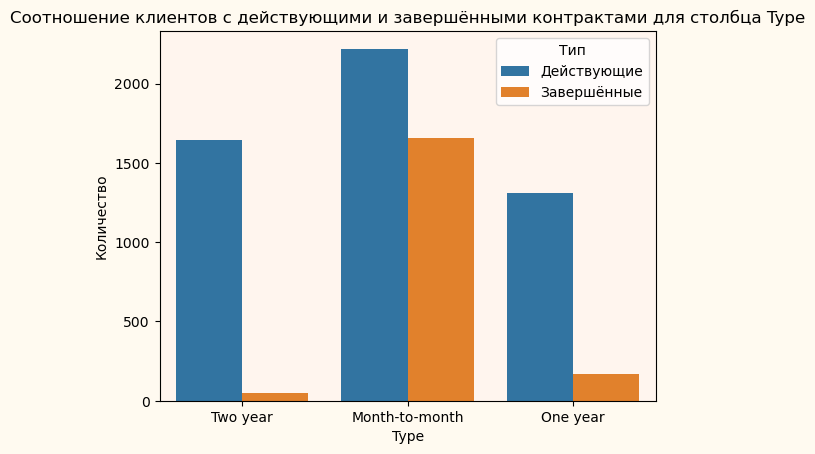

In [71]:
frac_visual(df, 'Type')

Видим, что чаще всего уходят клиенты, которые платят помесячно.

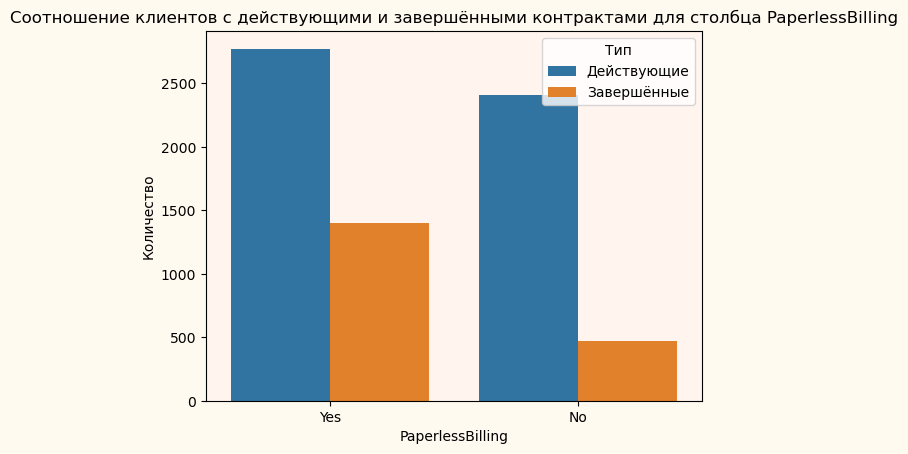

In [72]:
frac_visual(df, 'PaperlessBilling')

Среди пользующихся электронным расчётом процент разорвавших контракт больше.

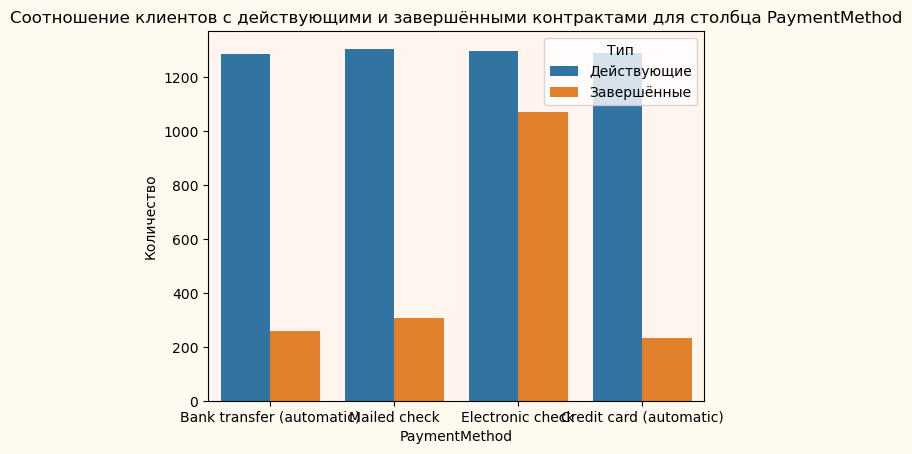

In [73]:
frac_visual(df, 'PaymentMethod')

Наблюдаем большой процент отказников среди тех, кто пользуется электронными чеками.

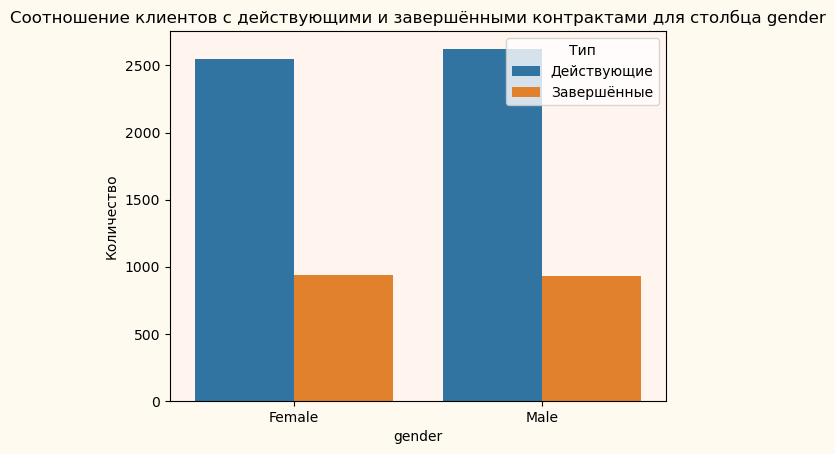

In [74]:
frac_visual(df, 'gender')

Пол влияния на отказ не оказывает.

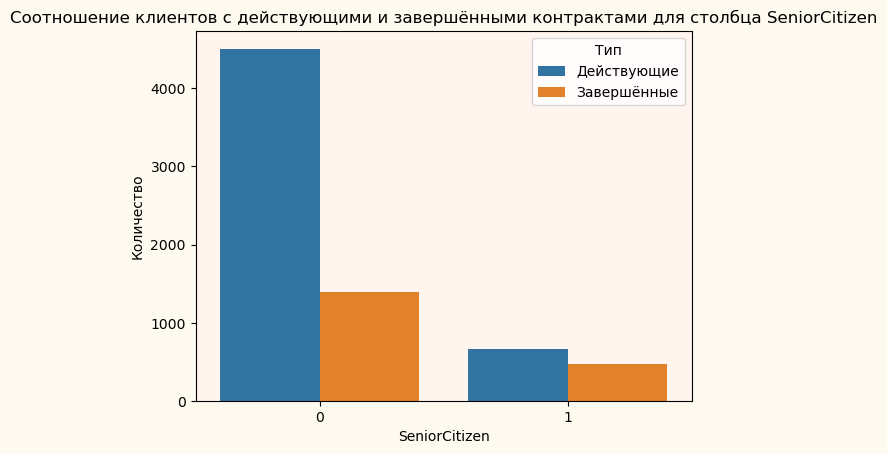

In [75]:
frac_visual(df, 'SeniorCitizen')

Процент отказов среди пенсионеров весьма высок.

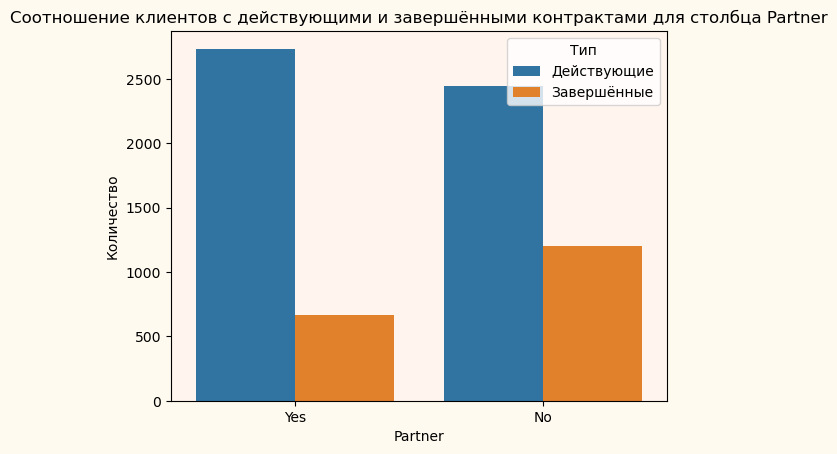

In [76]:
frac_visual(df, 'Partner')

Одинокие люди разрывают контракт чаще.

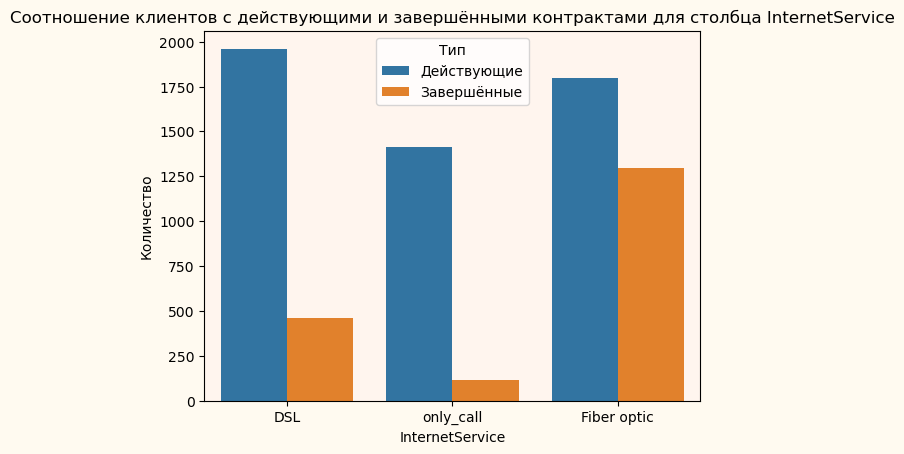

In [77]:
frac_visual(df, 'InternetService')

Процент отказников среди людей с детьми больше.

Большой процент отказов среди людей, пользующихся оптоволокном.

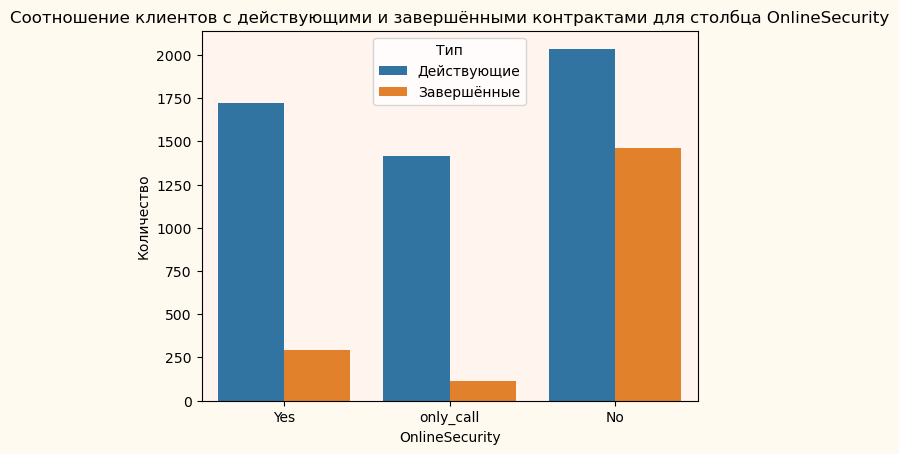

In [78]:
frac_visual(df, 'OnlineSecurity')

Большой процент отказников среди непользующихся защитой от опасных сайтов.

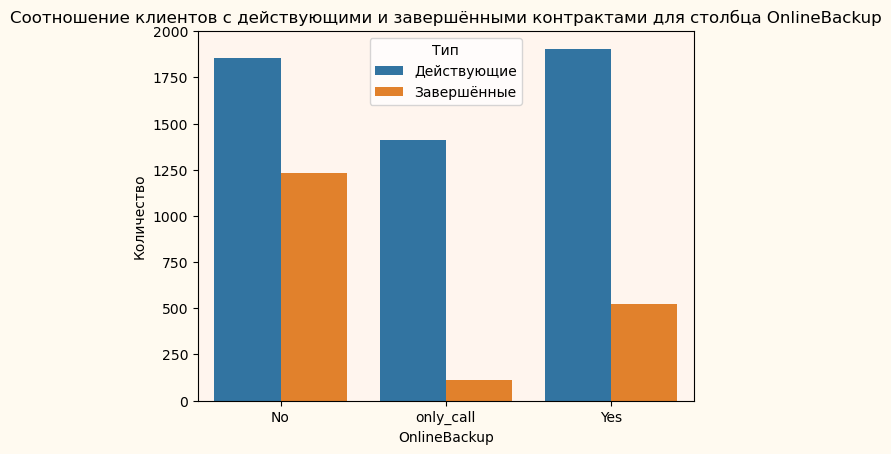

In [79]:
frac_visual(df, 'OnlineBackup')

Большой процент отказников среди непользующихся резервным копированием.

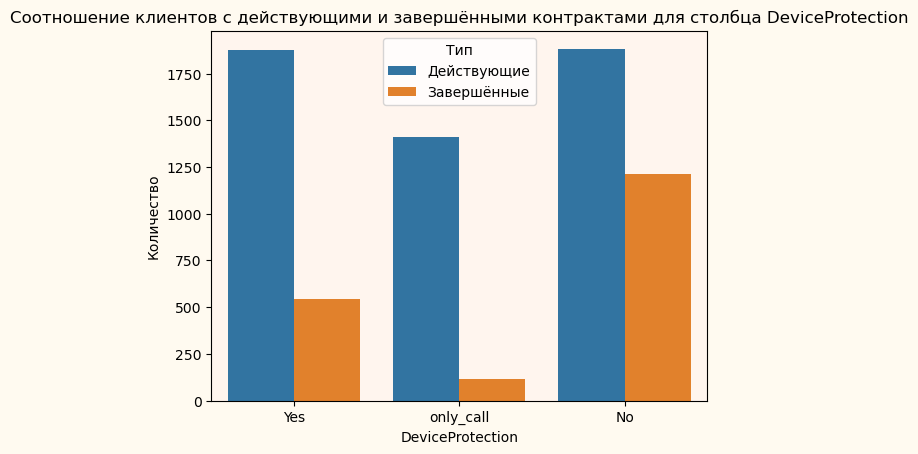

In [80]:
frac_visual(df, 'DeviceProtection')

Большой процент отказников среди непользующихся антивирусом.

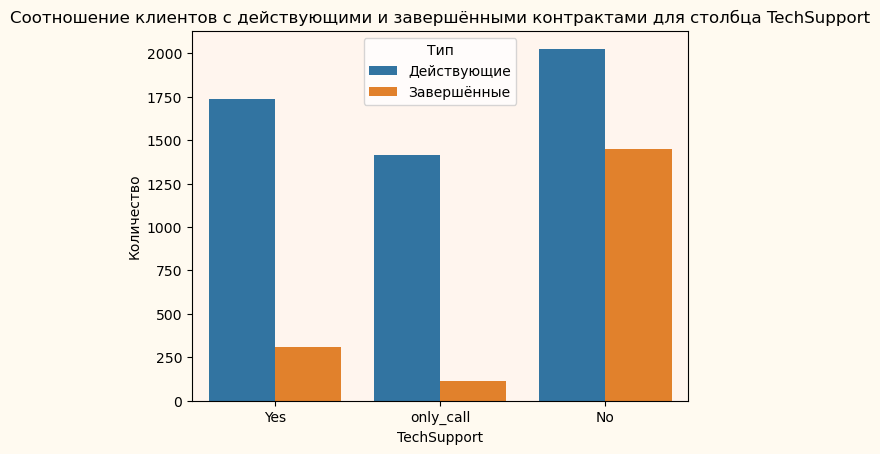

In [81]:
frac_visual(df, 'TechSupport')

Большой процент отказников среди непользующихся выделенной линией поддержки.

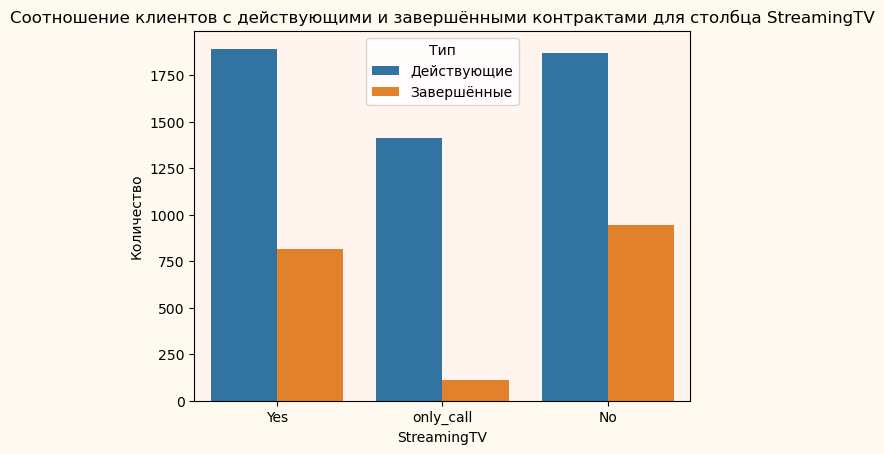

In [82]:
frac_visual(df, 'StreamingTV')

Похоже, что среди пользователей интернет-услугами примерно одинаковый процент отказников

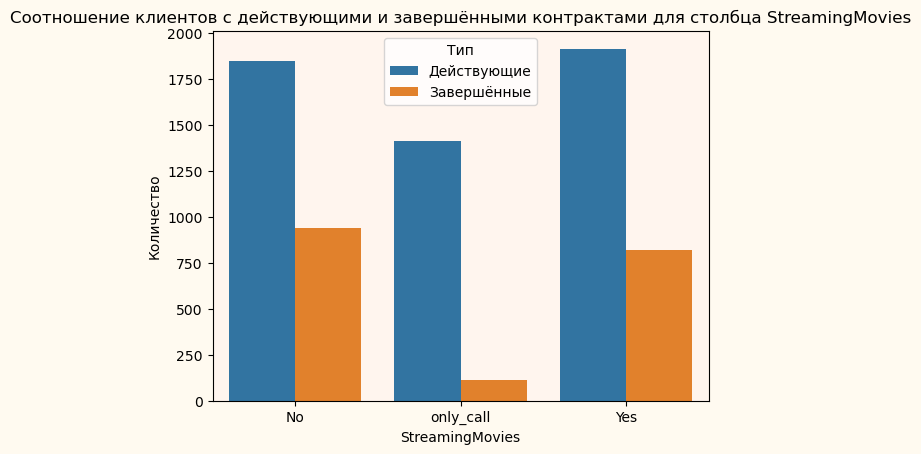

In [83]:
frac_visual(df, 'StreamingMovies')

Та же ситуация, что и с TV

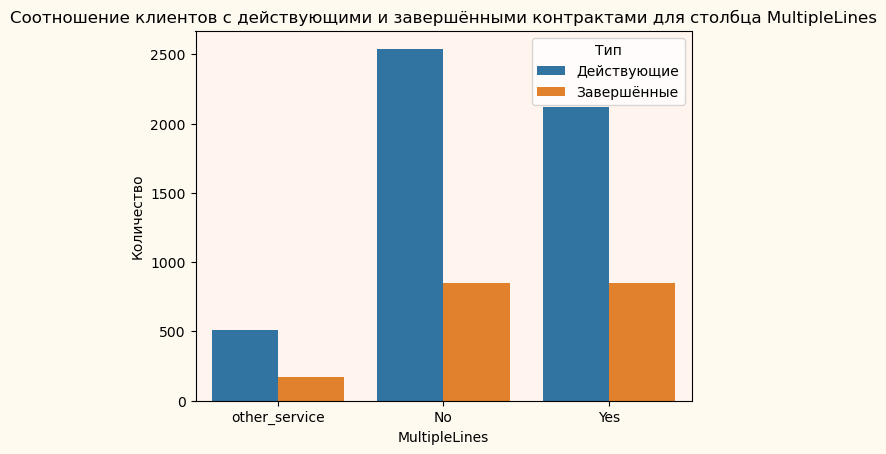

In [84]:
frac_visual(df, 'MultipleLines')

Та же ситуация, что и с двумя последними признаками

Посмотрим на дисбаланс классов

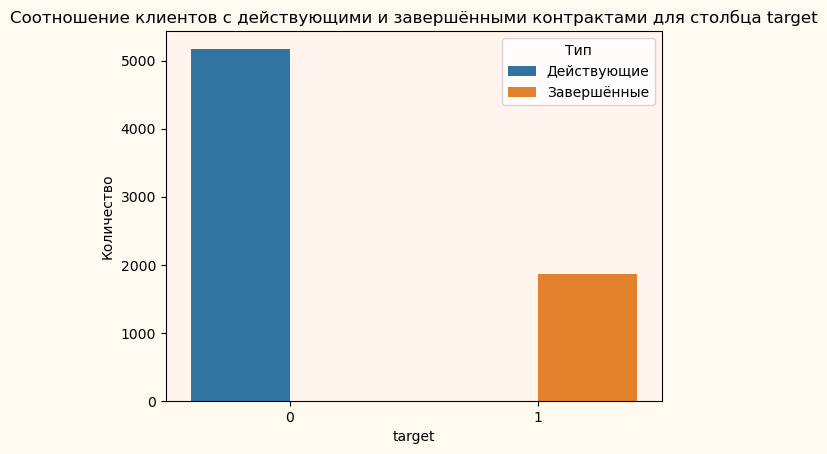

In [85]:
frac_visual(df, 'target')

Неравномерное распределение. Классы стоит сбалансировать.

В завершение можно сказать, что большой процент отказников среди тех, кто не пользуется услугами защиты, приоритетной технической поддержки и телевидением.

## Удаление не информативных признаков

In [86]:
df= df.drop(['customerID', 'BeginDate', 'EndDate'], axis=1)
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7043 entries, 0 to 7042
Data columns (total 19 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   Type              7043 non-null   object 
 1   PaperlessBilling  7043 non-null   object 
 2   PaymentMethod     7043 non-null   object 
 3   MonthlyCharges    7043 non-null   float64
 4   TotalCharges      7043 non-null   float64
 5   gender            7043 non-null   object 
 6   SeniorCitizen     7043 non-null   int64  
 7   Partner           7043 non-null   object 
 8   Dependents        7043 non-null   object 
 9   InternetService   7043 non-null   object 
 10  OnlineSecurity    7043 non-null   object 
 11  OnlineBackup      7043 non-null   object 
 12  DeviceProtection  7043 non-null   object 
 13  TechSupport       7043 non-null   object 
 14  StreamingTV       7043 non-null   object 
 15  StreamingMovies   7043 non-null   object 
 16  MultipleLines     7043 non-null   object 


`customerID` -- идентификационный номер, он по логике не нужен. `BeginDate`, `EndDate` -- заменяются параметром `contract_length`.

Является ли человек пенсионером -- категориальный признак. Изменим его тип:

In [87]:
df.SeniorCitizen = df.SeniorCitizen.astype(object)
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7043 entries, 0 to 7042
Data columns (total 19 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   Type              7043 non-null   object 
 1   PaperlessBilling  7043 non-null   object 
 2   PaymentMethod     7043 non-null   object 
 3   MonthlyCharges    7043 non-null   float64
 4   TotalCharges      7043 non-null   float64
 5   gender            7043 non-null   object 
 6   SeniorCitizen     7043 non-null   object 
 7   Partner           7043 non-null   object 
 8   Dependents        7043 non-null   object 
 9   InternetService   7043 non-null   object 
 10  OnlineSecurity    7043 non-null   object 
 11  OnlineBackup      7043 non-null   object 
 12  DeviceProtection  7043 non-null   object 
 13  TechSupport       7043 non-null   object 
 14  StreamingTV       7043 non-null   object 
 15  StreamingMovies   7043 non-null   object 
 16  MultipleLines     7043 non-null   object 


## Финальная проверка данных

Пропусков нет, но могут быть дубликаты:

In [88]:
df.duplicated().sum()

0

In [89]:
df.drop_duplicates(inplace=True)

In [90]:
df.reset_index(inplace=True, drop=True)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 19 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   Type              7043 non-null   object 
 1   PaperlessBilling  7043 non-null   object 
 2   PaymentMethod     7043 non-null   object 
 3   MonthlyCharges    7043 non-null   float64
 4   TotalCharges      7043 non-null   float64
 5   gender            7043 non-null   object 
 6   SeniorCitizen     7043 non-null   object 
 7   Partner           7043 non-null   object 
 8   Dependents        7043 non-null   object 
 9   InternetService   7043 non-null   object 
 10  OnlineSecurity    7043 non-null   object 
 11  OnlineBackup      7043 non-null   object 
 12  DeviceProtection  7043 non-null   object 
 13  TechSupport       7043 non-null   object 
 14  StreamingTV       7043 non-null   object 
 15  StreamingMovies   7043 non-null   object 
 16  MultipleLines     7043 non-null   object 


Выясним корреляцию между признаками

In [91]:
phik_target = df.phik_matrix(interval_cols=['TotalCharges', 'MonthlyCharges', 'contract_length']);

/Users/alexander/opt/anaconda3/lib/python3.9/site-packages/scipy/__init__.py:155: UserWarning: A NumPy version >=1.18.5 and <1.25.0 is required for this version of SciPy (detected version 1.26.4
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"
/Users/alexander/opt/anaconda3/lib/python3.9/site-packages/scipy/__init__.py:155: UserWarning: A NumPy version >=1.18.5 and <1.25.0 is required for this version of SciPy (detected version 1.26.4
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"
/Users/alexander/opt/anaconda3/lib/python3.9/site-packages/scipy/__init__.py:155: UserWarning: A NumPy version >=1.18.5 and <1.25.0 is required for this version of SciPy (detected version 1.26.4
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"
/Users/alexander/opt/anaconda3/lib/python3.9/site-packages/scipy/__init__.py:155: UserWarning: A NumPy version >=1.18.5 and <1.25.0 is required for this version of SciPy (detected version 1.26.

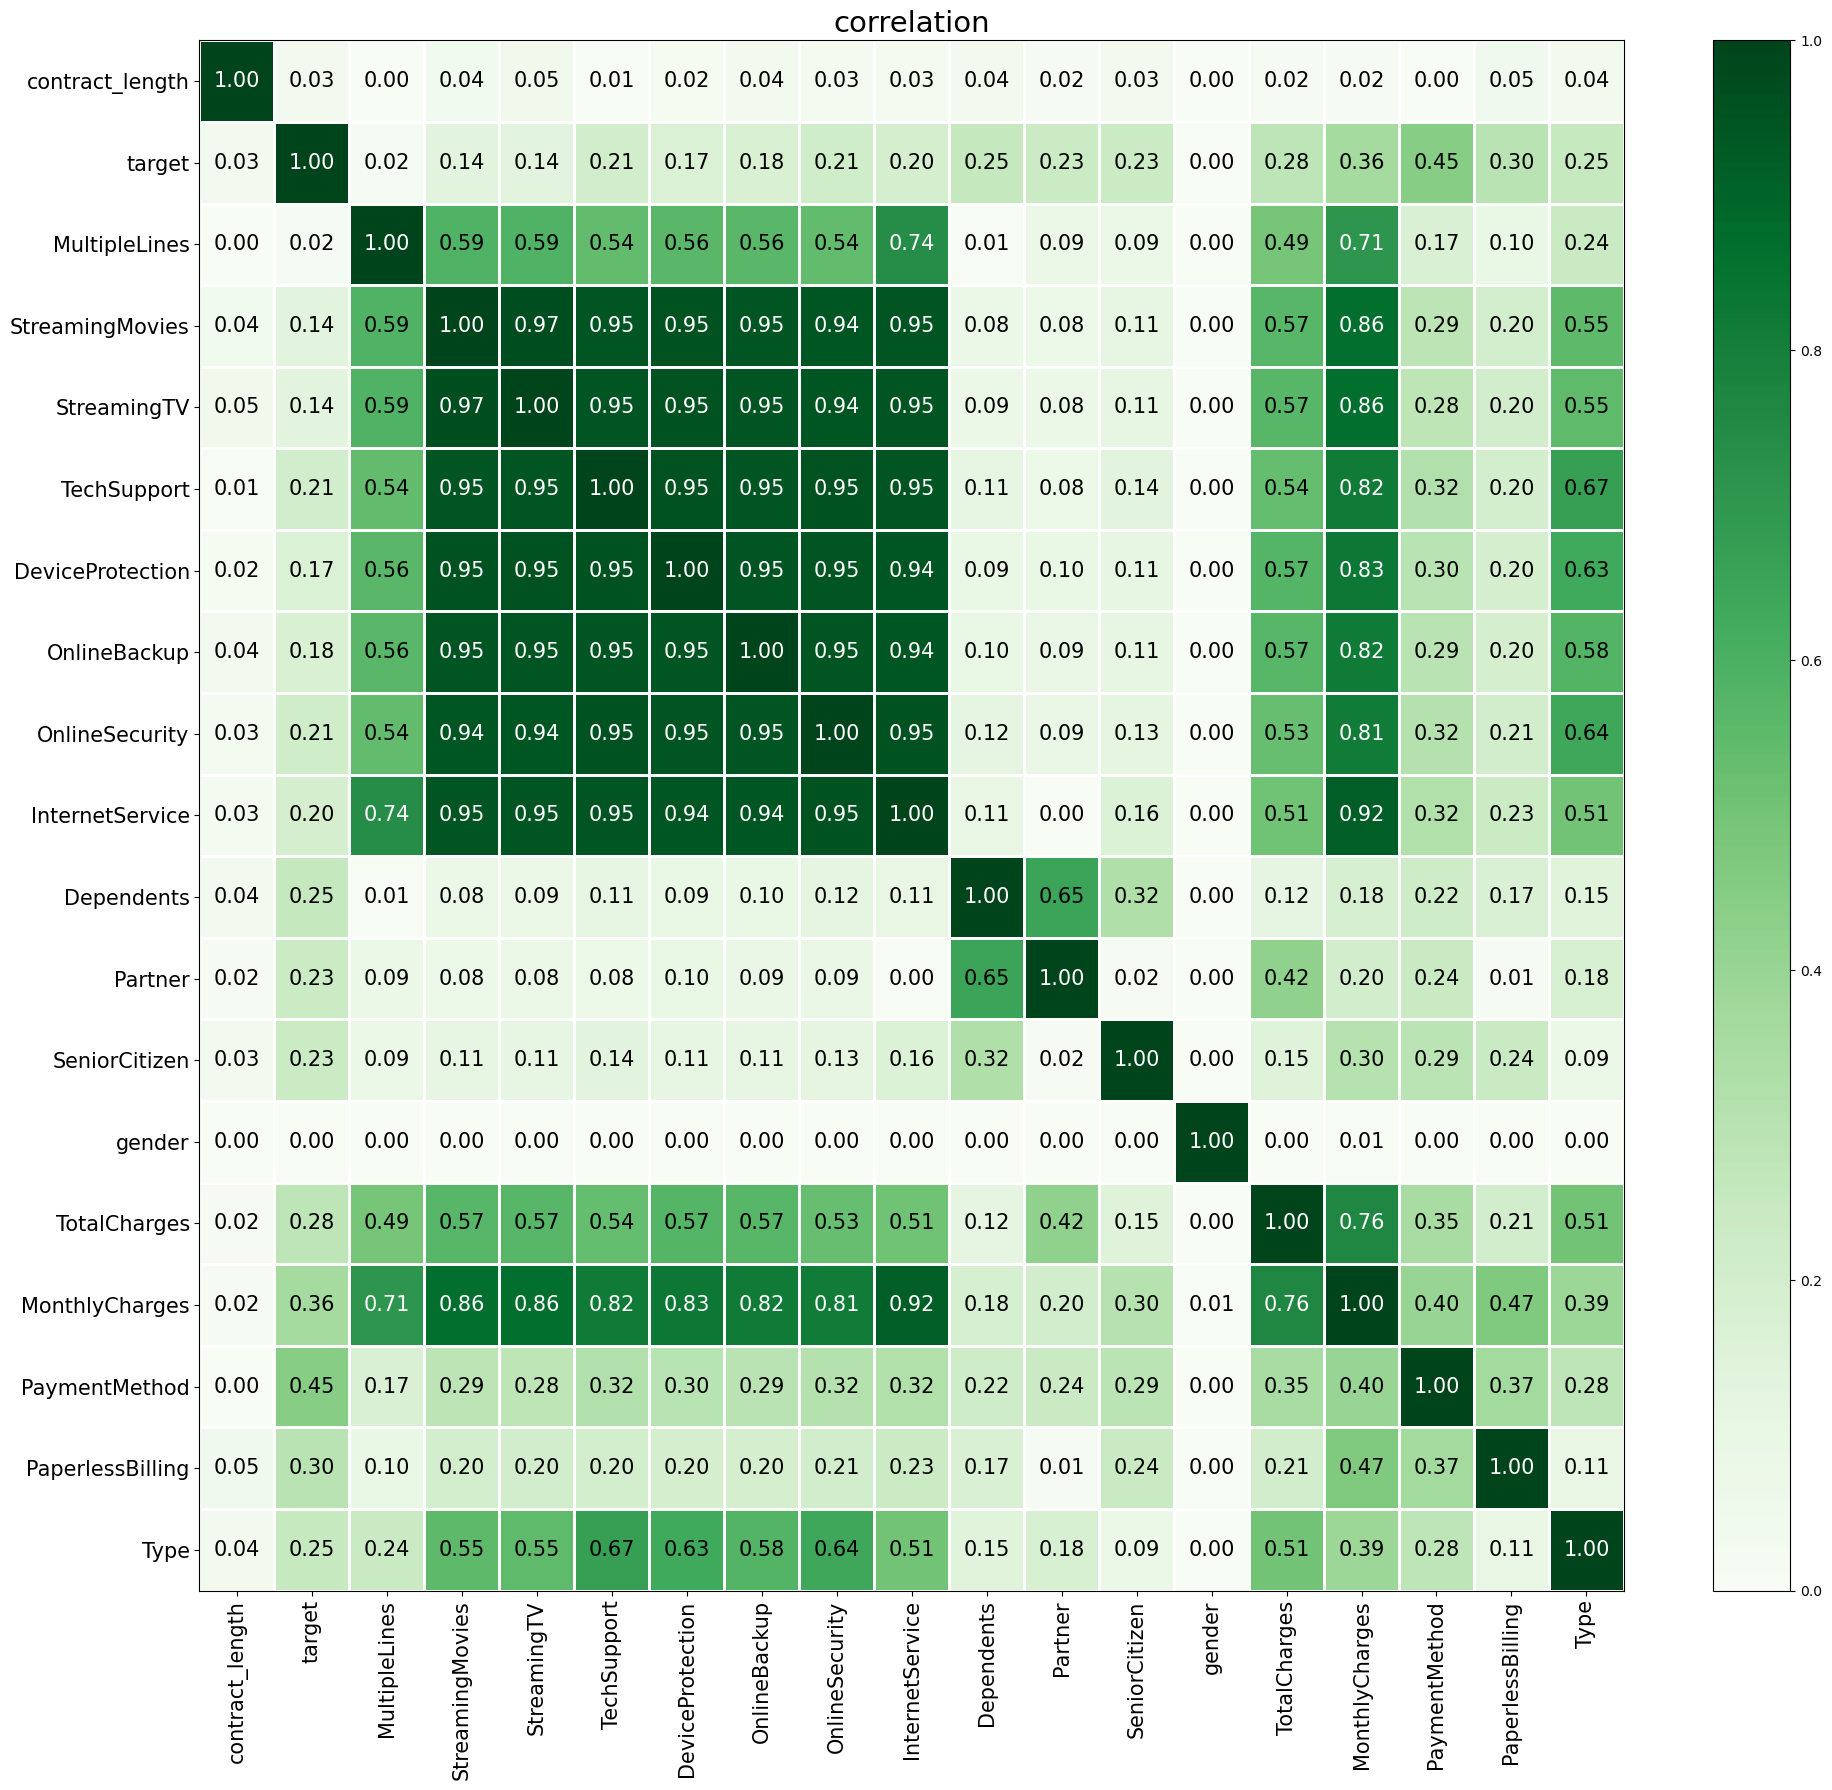

In [92]:
plot_correlation_matrix(phik_target.values,
                        x_labels=phik_target.columns,
                        y_labels=phik_target.index,
                        vmin=0, vmax=1, color_map="Greens",

                        fontsize_factor=1.5,
                        figsize=(20, 18))
plt.tight_layout()

### Промежуточный вывод

Корреляционный анализ показал, что есть группы сильно коррелирующих признаков. Так, все данные из таблицы telecom.internet: `StreamingMovies`, `StreamingTV`, `TechSupport`, `DeviceProtection`, `OnlineBackup`, `OnlineSecurity`, `InternetService` силько связаны. Более того, эти признаки оказывают влияние на `MonthlyCharges`, `TotalCharges` и `Type`. Это означает, что клиенты зависимы от подключения к дополнительным функциям, от которых также зависят расходы

# Подготовка данных к обучению

Выделим основные признаки датасета для обучения

In [93]:
df.head(3)

,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,gender,SeniorCitizen,Partner,Dependents,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,MultipleLines,target,contract_length
0,Two year,Yes,Bank transfer (automatic),52.55,0.00,Female,0,Yes,Yes,DSL,Yes,No,Yes,Yes,Yes,No,other_service,0,0
1,Two year,No,Mailed check,20.25,0.00,Male,0,No,Yes,only_call,only_call,only_call,only_call,only_call,only_call,only_call,No,0,0
2,Month-to-month,Yes,Mailed check,53.85,108.15,Male,0,No,No,DSL,Yes,Yes,No,No,No,No,No,1,479


In [94]:
df = df.drop(['gender', 'MultipleLines', 'contract_length', 'OnlineSecurity', 'OnlineBackup', 'DeviceProtection', 'OnlineSecurity', 'OnlineBackup', 'TechSupport', 'StreamingTV', 'StreamingMovies'], axis=1)



Разделим данные на обучающую и тестовые выборки:

Проведём финальную проверку данных. Пропусков нет, но могут быть дубликаты:

In [95]:
target = df.target
features = df.drop(['target'], axis=1)

features_train, features_test, target_train, target_test = \
train_test_split(features, target, test_size=0.25, random_state=random_state, stratify=df.target)

In [96]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 10 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   Type              7043 non-null   object 
 1   PaperlessBilling  7043 non-null   object 
 2   PaymentMethod     7043 non-null   object 
 3   MonthlyCharges    7043 non-null   float64
 4   TotalCharges      7043 non-null   float64
 5   SeniorCitizen     7043 non-null   object 
 6   Partner           7043 non-null   object 
 7   Dependents        7043 non-null   object 
 8   InternetService   7043 non-null   object 
 9   target            7043 non-null   int64  
dtypes: float64(2), int64(1), object(7)
memory usage: 550.4+ KB


In [97]:
L_numeric = []
L_object = []

for col in features.columns:
    if is_numeric_dtype(df[col]):
        L_numeric.append(col)
    else:
        L_object.append(col)

Инициализация кодировщика:

In [98]:
encoder = OrdinalEncoder(handle_unknown = 'use_encoded_value', unknown_value=11)

Кодируем категориальные признаки:

In [99]:
l1 = features_train[L_object]
l2 = features_test[L_object]

l1 = pd.DataFrame(encoder.fit_transform(l1), columns=L_object)
l2 = pd.DataFrame(encoder.transform(l2), columns=L_object)

Масштабируем количественные признаки:

Инициализация инструмента:

In [100]:
scaler = StandardScaler()

Масштабирование:

In [101]:
l3 = features_train[L_numeric]
l4 = features_test[L_numeric]

l3 = pd.DataFrame(scaler.fit_transform(l3), columns=L_numeric)
l4 = pd.DataFrame(scaler.transform(l4), columns=L_numeric)

Объединение в один датафрейм:

In [102]:
features_train = pd.concat([l1, l3], axis=1)
features_test = pd.concat([l2, l4], axis=1)

Посмотрим, что получилось:

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5282 entries, 0 to 5281
Data columns (total 9 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   Type              5282 non-null   float64
 1   PaperlessBilling  5282 non-null   float64
 2   PaymentMethod     5282 non-null   float64
 3   SeniorCitizen     5282 non-null   float64
 4   Partner           5282 non-null   float64
 5   Dependents        5282 non-null   float64
 6   InternetService   5282 non-null   float64
 7   MonthlyCharges    5282 non-null   float64
 8   TotalCharges      5282 non-null   float64
dtypes: float64(9)
memory usage: 371.5 KB



,Type,PaperlessBilling,PaymentMethod,SeniorCitizen,Partner,Dependents,InternetService,MonthlyCharges,TotalCharges
1091,0.0,1.0,2.0,0.0,1.0,1.0,2.0,-1.305953,-0.828717
127,2.0,0.0,0.0,0.0,0.0,0.0,2.0,-1.370518,-0.651101
4306,1.0,1.0,3.0,0.0,1.0,0.0,0.0,-0.012999,0.502903
1894,0.0,1.0,3.0,0.0,0.0,0.0,0.0,-0.296091,-0.885192
3928,0.0,1.0,2.0,0.0,0.0,1.0,0.0,-1.324164,-0.992158


Numeric Describe:


,Type,PaperlessBilling,PaymentMethod,SeniorCitizen,Partner,Dependents,InternetService,MonthlyCharges,TotalCharges
count,5282.000000,5282.000000,5282.000000,5282.000000,5282.000000,5282.000000,5282.000000,5.282000e+03,5.282000e+03
mean,0.688944,0.591632,1.582166,0.165089,0.480689,0.296668,0.877509,1.893180e-16,1.238018e-17
std,0.834307,0.491578,1.068284,0.371296,0.499674,0.456832,0.735621,1.000095e+00,1.000095e+00
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-1.532758e+00,-1.003065e+00
25%,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,-9.682291e-01,-8.267518e-01
50%,0.000000,1.000000,2.000000,0.000000,0.000000,0.000000,1.000000,1.856624e-01,-3.936747e-01
75%,1.000000,1.000000,2.000000,0.000000,1.000000,1.000000,1.000000,8.362784e-01,6.539533e-01
max,2.000000,1.000000,3.000000,1.000000,1.000000,1.000000,2.000000,1.789853e+00,2.831752e+00


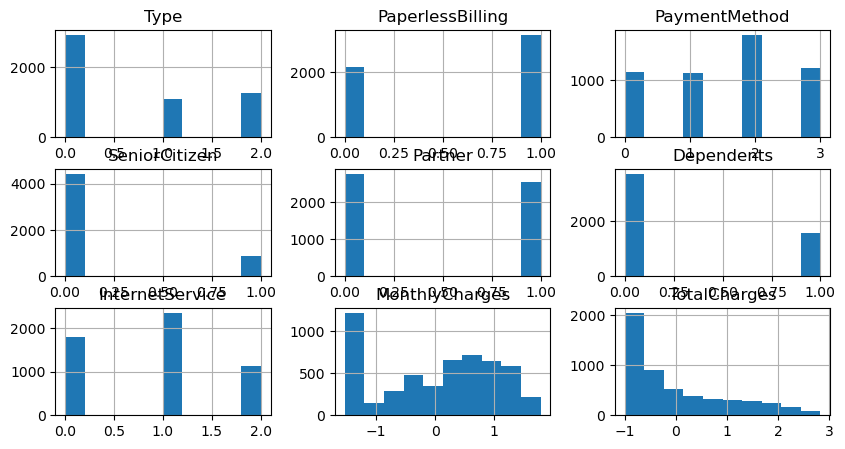

In [103]:
describe_table(features_train)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1761 entries, 0 to 1760
Data columns (total 9 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   Type              1761 non-null   float64
 1   PaperlessBilling  1761 non-null   float64
 2   PaymentMethod     1761 non-null   float64
 3   SeniorCitizen     1761 non-null   float64
 4   Partner           1761 non-null   float64
 5   Dependents        1761 non-null   float64
 6   InternetService   1761 non-null   float64
 7   MonthlyCharges    1761 non-null   float64
 8   TotalCharges      1761 non-null   float64
dtypes: float64(9)
memory usage: 123.9 KB



,Type,PaperlessBilling,PaymentMethod,SeniorCitizen,Partner,Dependents,InternetService,MonthlyCharges,TotalCharges
1507,0.0,1.0,2.0,0.0,0.0,0.0,1.0,0.679005,-0.793414
1689,0.0,1.0,3.0,1.0,0.0,0.0,0.0,0.167452,-0.320686
449,0.0,0.0,1.0,0.0,1.0,1.0,0.0,0.510143,-0.026433
886,1.0,0.0,2.0,0.0,1.0,0.0,1.0,1.149170,1.231093
349,0.0,1.0,2.0,1.0,0.0,0.0,1.0,0.503521,-0.887863


Numeric Describe:


,Type,PaperlessBilling,PaymentMethod,SeniorCitizen,Partner,Dependents,InternetService,MonthlyCharges,TotalCharges
count,1761.000000,1761.000000,1761.000000,1761.000000,1761.000000,1761.000000,1761.000000,1761.000000,1761.000000
mean,0.695060,0.593981,1.550823,0.153322,0.490062,0.308348,0.859171,0.009150,0.014251
std,0.832318,0.491228,1.067522,0.360400,0.500043,0.461942,0.744325,0.985033,1.003578
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-1.537725,-0.994675
25%,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,-0.946707,-0.829688
50%,0.000000,1.000000,2.000000,0.000000,0.000000,0.000000,1.000000,0.195595,-0.371796
75%,1.000000,1.000000,2.000000,0.000000,1.000000,1.000000,1.000000,0.826345,0.709131
max,2.000000,1.000000,3.000000,1.000000,1.000000,1.000000,2.000000,1.751776,2.763179


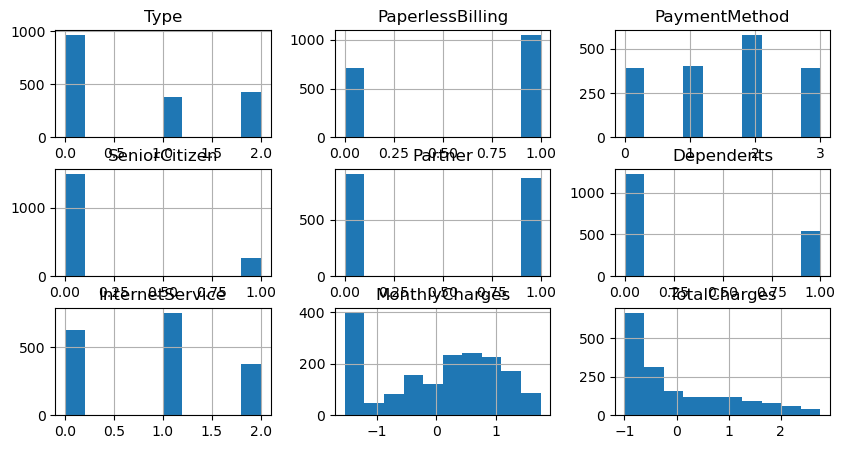

In [104]:
describe_table(features_test)

In [105]:
print(features.shape, target.shape)
print(features_train.shape, target_train.shape)
print(features_test.shape, target_test.shape)

(7043, 9) (7043,)
(5282, 9) (5282,)
(1761, 9) (1761,)


# Обучение моделей

## Модель решающего дерева

Гиперпараметры будем подбирать методом автоматизированного подбора `GridSearchCV`:

In [106]:
tree_model = DecisionTreeClassifier(class_weight='balanced',\
                                    random_state=random_state)

In [107]:
tree_model_parameters = {'max_depth': range(1,10)}

grid_search_tree_model = GridSearchCV(tree_model,\
                               tree_model_parameters,\
                               verbose=3,\
                               cv=8,\
                               n_jobs=-1,\
                               scoring='roc_auc')


grid_search_tree_model.fit(features_train, target_train);

Fitting 8 folds for each of 9 candidates, totalling 72 fits


Результаты:

In [108]:
print(grid_search_tree_model.best_score_)
print(grid_search_tree_model.best_params_)

0.8266062474896239
{'max_depth': 5}


## RandomForestClassifier

In [109]:
forest_model = RandomForestClassifier(class_weight='balanced',\
                                    random_state=random_state)
forest_model_parameters = {'max_depth': range(1,10),
                           'n_estimators': range(100, 500, 100),
                           'criterion': ['gini', 'entropy', 'log_loss']}

grid_search_forest_model = GridSearchCV(forest_model,\
                               forest_model_parameters,\
                               verbose=3,\
                               cv=3,\
                               n_jobs=-1,\
                               scoring='roc_auc')


grid_search_forest_model.fit(features_train, target_train)

Fitting 3 folds for each of 108 candidates, totalling 324 fits


GridSearchCV(cv=3,
             estimator=RandomForestClassifier(class_weight='balanced',
                                              random_state=80524),
             n_jobs=-1,
             param_grid={'criterion': ['gini', 'entropy', 'log_loss'],
                         'max_depth': range(1, 10),
                         'n_estimators': range(100, 500, 100)},
             scoring='roc_auc', verbose=3)

In [110]:
print(grid_search_forest_model.best_score_)
print(grid_search_forest_model.best_params_)

0.8429709879955305
{'criterion': 'entropy', 'max_depth': 6, 'n_estimators': 400}


## Модель CatBoostClassifier

## Модель LGBMClassifier

In [111]:
lgbm_model = LGBMClassifier(objective='binary',\
                            random_state=random_state)


lgbm_model_parameters = {'n_estimators': range(1,31),
                         'max_depth': range(1,10,1),
                         'boosting_type': ['gbdt', 'dart', 'rf']}

In [112]:
grid_search_lgbm_model = GridSearchCV(lgbm_model,\
                               lgbm_model_parameters,\
                               verbose=3,\
                               cv=3,\
                               n_jobs=-1,\
                               scoring='roc_auc')


grid_search_lgbm_model.fit(features_train, target_train);

Fitting 3 folds for each of 810 candidates, totalling 2430 fits
[CV 4/8] END .......................max_depth=1;, score=0.742 total time=   0.0s
[CV 1/8] END .......................max_depth=2;, score=0.789 total time=   0.0s
[CV 3/8] END .......................max_depth=2;, score=0.768 total time=   0.0s
[CV 1/8] END .......................max_depth=3;, score=0.823 total time=   0.0s
[CV 2/8] END .......................max_depth=3;, score=0.803 total time=   0.0s
[CV 1/8] END .......................max_depth=4;, score=0.837 total time=   0.0s
[CV 2/8] END .......................max_depth=4;, score=0.815 total time=   0.0s
[CV 5/8] END .......................max_depth=5;, score=0.853 total time=   0.0s
[CV 6/8] END .......................max_depth=5;, score=0.799 total time=   0.0s
[CV 2/8] END .......................max_depth=7;, score=0.776 total time=   0.0s
[CV 7/8] END .......................max_depth=7;, score=0.826 total time=   0.0s
[CV 8/8] END .......................max_depth

[LightGBM] [Fatal] Check failed: config->bagging_freq > 0 && config->bagging_fraction < 1.0f && config->bagging_fraction > 0.0f at /private/var/folders/nz/j6p8yfhx1mv_0grj5xl4650h0000gp/T/abs_8a4323bdvv/croot/lightgbm_1677766506188/work/compile/src/boosting/rf.hpp, line 35 .

[LightGBM] [Fatal] Check failed: config->bagging_freq > 0 && config->bagging_fraction < 1.0f && config->bagging_fraction > 0.0f at /private/var/folders/nz/j6p8yfhx1mv_0grj5xl4650h0000gp/T/abs_8a4323bdvv/croot/lightgbm_1677766506188/work/compile/src/boosting/rf.hpp, line 35 .

[LightGBM] [Fatal] Check failed: config->bagging_freq > 0 && config->bagging_fraction < 1.0f && config->bagging_fraction > 0.0f at /private/var/folders/nz/j6p8yfhx1mv_0grj5xl4650h0000gp/T/abs_8a4323bdvv/croot/lightgbm_1677766506188/work/compile/src/boosting/rf.hpp, line 35 .

[LightGBM] [Fatal] Check failed: config->bagging_freq > 0 && config->bagging_fraction < 1.0f && config->bagging_fraction > 0.0f at /private/var/folders/nz/j6p8yfhx1mv_0g

[CV 8/8] END .......................max_depth=1;, score=0.729 total time=   0.0s
[CV 1/3] END criterion=gini, max_depth=1, n_estimators=200;, score=0.813 total time=   0.2s
[CV 1/3] END criterion=gini, max_depth=2, n_estimators=100;, score=0.819 total time=   0.1s
[CV 1/3] END criterion=gini, max_depth=2, n_estimators=300;, score=0.824 total time=   0.4s
[CV 2/3] END criterion=gini, max_depth=2, n_estimators=300;, score=0.839 total time=   0.4s
[CV 3/3] END criterion=gini, max_depth=4, n_estimators=100;, score=0.833 total time=   0.2s
[CV 1/3] END criterion=gini, max_depth=4, n_estimators=200;, score=0.831 total time=   0.3s
[CV 3/3] END criterion=gini, max_depth=5, n_estimators=100;, score=0.838 total time=   0.2s
[CV 1/3] END criterion=gini, max_depth=5, n_estimators=200;, score=0.835 total time=   0.5s
[CV 1/3] END criterion=gini, max_depth=6, n_estimators=100;, score=0.835 total time=   0.2s
[CV 2/3] END criterion=gini, max_depth=6, n_estimators=100;, score=0.853 total time=   0.2s

[LightGBM] [Fatal] Check failed: config->bagging_freq > 0 && config->bagging_fraction < 1.0f && config->bagging_fraction > 0.0f at /private/var/folders/nz/j6p8yfhx1mv_0grj5xl4650h0000gp/T/abs_8a4323bdvv/croot/lightgbm_1677766506188/work/compile/src/boosting/rf.hpp, line 35 .

[LightGBM] [Fatal] Check failed: config->bagging_freq > 0 && config->bagging_fraction < 1.0f && config->bagging_fraction > 0.0f at /private/var/folders/nz/j6p8yfhx1mv_0grj5xl4650h0000gp/T/abs_8a4323bdvv/croot/lightgbm_1677766506188/work/compile/src/boosting/rf.hpp, line 35 .

[LightGBM] [Fatal] Check failed: config->bagging_freq > 0 && config->bagging_fraction < 1.0f && config->bagging_fraction > 0.0f at /private/var/folders/nz/j6p8yfhx1mv_0grj5xl4650h0000gp/T/abs_8a4323bdvv/croot/lightgbm_1677766506188/work/compile/src/boosting/rf.hpp, line 35 .

[LightGBM] [Fatal] Check failed: config->bagging_freq > 0 && config->bagging_fraction < 1.0f && config->bagging_fraction > 0.0f at /private/var/folders/nz/j6p8yfhx1mv_0g

[CV 1/8] END .......................max_depth=1;, score=0.751 total time=   0.0s
[CV 2/8] END .......................max_depth=2;, score=0.774 total time=   0.0s
[CV 5/8] END .......................max_depth=2;, score=0.809 total time=   0.0s
[CV 8/8] END .......................max_depth=2;, score=0.766 total time=   0.0s
[CV 7/8] END .......................max_depth=5;, score=0.833 total time=   0.0s
[CV 8/8] END .......................max_depth=5;, score=0.806 total time=   0.0s
[CV 4/8] END .......................max_depth=7;, score=0.836 total time=   0.0s
[CV 8/8] END .......................max_depth=8;, score=0.780 total time=   0.0s
[CV 6/8] END .......................max_depth=9;, score=0.787 total time=   0.0s
[CV 2/3] END criterion=gini, max_depth=1, n_estimators=300;, score=0.825 total time=   0.3s
[CV 1/3] END criterion=gini, max_depth=2, n_estimators=200;, score=0.823 total time=   0.2s
[CV 2/3] END criterion=gini, max_depth=3, n_estimators=200;, score=0.847 total time=   

[LightGBM] [Fatal] Check failed: config->bagging_freq > 0 && config->bagging_fraction < 1.0f && config->bagging_fraction > 0.0f at /private/var/folders/nz/j6p8yfhx1mv_0grj5xl4650h0000gp/T/abs_8a4323bdvv/croot/lightgbm_1677766506188/work/compile/src/boosting/rf.hpp, line 35 .

[LightGBM] [Fatal] Check failed: config->bagging_freq > 0 && config->bagging_fraction < 1.0f && config->bagging_fraction > 0.0f at /private/var/folders/nz/j6p8yfhx1mv_0grj5xl4650h0000gp/T/abs_8a4323bdvv/croot/lightgbm_1677766506188/work/compile/src/boosting/rf.hpp, line 35 .

[LightGBM] [Fatal] Check failed: config->bagging_freq > 0 && config->bagging_fraction < 1.0f && config->bagging_fraction > 0.0f at /private/var/folders/nz/j6p8yfhx1mv_0grj5xl4650h0000gp/T/abs_8a4323bdvv/croot/lightgbm_1677766506188/work/compile/src/boosting/rf.hpp, line 35 .

[LightGBM] [Fatal] Check failed: config->bagging_freq > 0 && config->bagging_fraction < 1.0f && config->bagging_fraction > 0.0f at /private/var/folders/nz/j6p8yfhx1mv_0g

[LightGBM] [Fatal] Check failed: config->bagging_freq > 0 && config->bagging_fraction < 1.0f && config->bagging_fraction > 0.0f at /private/var/folders/nz/j6p8yfhx1mv_0grj5xl4650h0000gp/T/abs_8a4323bdvv/croot/lightgbm_1677766506188/work/compile/src/boosting/rf.hpp, line 35 .

[LightGBM] [Fatal] Check failed: config->bagging_freq > 0 && config->bagging_fraction < 1.0f && config->bagging_fraction > 0.0f at /private/var/folders/nz/j6p8yfhx1mv_0grj5xl4650h0000gp/T/abs_8a4323bdvv/croot/lightgbm_1677766506188/work/compile/src/boosting/rf.hpp, line 35 .

[LightGBM] [Fatal] Check failed: config->bagging_freq > 0 && config->bagging_fraction < 1.0f && config->bagging_fraction > 0.0f at /private/var/folders/nz/j6p8yfhx1mv_0grj5xl4650h0000gp/T/abs_8a4323bdvv/croot/lightgbm_1677766506188/work/compile/src/boosting/rf.hpp, line 35 .

[LightGBM] [Fatal] Check failed: config->bagging_freq > 0 && config->bagging_fraction < 1.0f && config->bagging_fraction > 0.0f at /private/var/folders/nz/j6p8yfhx1mv_0g

[LightGBM] [Fatal] Check failed: config->bagging_freq > 0 && config->bagging_fraction < 1.0f && config->bagging_fraction > 0.0f at /private/var/folders/nz/j6p8yfhx1mv_0grj5xl4650h0000gp/T/abs_8a4323bdvv/croot/lightgbm_1677766506188/work/compile/src/boosting/rf.hpp, line 35 .

[LightGBM] [Fatal] Check failed: config->bagging_freq > 0 && config->bagging_fraction < 1.0f && config->bagging_fraction > 0.0f at /private/var/folders/nz/j6p8yfhx1mv_0grj5xl4650h0000gp/T/abs_8a4323bdvv/croot/lightgbm_1677766506188/work/compile/src/boosting/rf.hpp, line 35 .

[LightGBM] [Fatal] Check failed: config->bagging_freq > 0 && config->bagging_fraction < 1.0f && config->bagging_fraction > 0.0f at /private/var/folders/nz/j6p8yfhx1mv_0grj5xl4650h0000gp/T/abs_8a4323bdvv/croot/lightgbm_1677766506188/work/compile/src/boosting/rf.hpp, line 35 .

[LightGBM] [Fatal] Check failed: config->bagging_freq > 0 && config->bagging_fraction < 1.0f && config->bagging_fraction > 0.0f at /private/var/folders/nz/j6p8yfhx1mv_0g

Результаты:

In [113]:
model_best = grid_search_lgbm_model.best_estimator_
model_best.fit(features_train, target_train);

In [114]:
print(grid_search_lgbm_model.best_score_)
print(grid_search_lgbm_model.best_params_)

0.8420183148150663
{'boosting_type': 'gbdt', 'max_depth': 4, 'n_estimators': 30}


## Полносвязная нейронная сеть

Готовим тензоры:

In [115]:
X_train = torch.FloatTensor(features_train.values)
y_train = torch.FloatTensor(target_train.values)

n_in_neurons = X_train.shape[1]
n_in_neurons

9

Инициализируем и обучаем модель:

In [116]:
class Net(nn.Module):
    def __init__(self, n_in_neurons, n_hidden_neurons_1, n_hidden_neurons_2, n_hidden_neurons_3, dropout_rate=0.9):  #dropout_rate=0.7
        super(Net, self).__init__()
        self.fc1 = nn.Linear(n_in_neurons, n_hidden_neurons_1)
#         self.relu = nn.LeakyReLU(0.15) SiLU
#         self.bn1 = nn.BatchNorm1d(n_hidden_neurons_1)
        self.relu = nn.SiLU()
#         self.relu = nn.ReLU()
        self.dropout = nn.Dropout(p=dropout_rate)

        self.fc2 = nn.Linear(n_hidden_neurons_1, n_hidden_neurons_2)
# #         self.relu = nn.LeakyReLU(0.2)
#         self.bn2 = nn.BatchNorm1d(n_hidden_neurons_2)
        self.relu = nn.Sigmoid()
#         self.relu = nn.ReLU()
        self.dropout = nn.Dropout(p=dropout_rate)

        self.fc3 = nn.Linear(n_hidden_neurons_2, n_hidden_neurons_3)
# #         self.relu = nn.LeakyReLU(0.2)
#         self.bn3 = nn.BatchNorm1d(n_hidden_neurons_3)
        self.relu = nn.SiLU()
# #         self.relu = nn.ReLU()
        self.dropout = nn.Dropout(p=dropout_rate)

        self.fc4 = nn.Linear(n_hidden_neurons_3, 1)

#         nn.init.uniform_(self.fc1.weight, a=1, b=2)
#         nn.init.uniform_(self.fc1.bias, a=1, b=2)
#         nn.init.kaiming_uniform_(self.fc2.weight, mode='fan_in', nonlinearity='relu')
#         nn.init.normal_(self.fc2.bias, mean=0, std=1)
#         nn.init.kaiming_normal_(self.fc3.weight)
#         nn.init.normal_(self.fc3.bias, mean=0, std=1)


    def forward(self, x):
        x = self.fc1(x)
#         x = self.bn1(x)
        x = self.relu(x)
        x = self.dropout(x)

        x = self.fc2(x)
#         x = self.bn2(x)
        x = self.relu(x)
        x = self.dropout(x)

        x = self.fc3(x)
#         x = self.bn3(x)
        x = self.relu(x)
        x = self.dropout(x)

        x = self.fc4(x)
        return x

In [117]:
n_hidden_neurons_1 = 64
n_hidden_neurons_2 = 71
n_hidden_neurons_3 = 55
loss = nn.BCEWithLogitsLoss()

In [118]:
%%time

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=random_state)

batch_size = 50

num_epochs = 100

num_batches = ceil(len(X_train)/batch_size)


best_epoch = 0
best_net = None
ROC_AUC_MAX_VAL = 0
S = []


for fold, (train_idx, val_idx) in enumerate(cv.split(X_train, y_train)):
    X_train_fold, y_train_fold = X_train[train_idx], y_train[train_idx]
    X_val_fold, y_val_fold = X_train[val_idx], y_train[val_idx]

    net = Net(n_in_neurons, n_hidden_neurons_1, n_hidden_neurons_2, n_hidden_neurons_3)

    optimizer = torch.optim.Adam(net.parameters(), lr=1e-3)

    ss = 0

    for epoch in range(num_epochs):
        order = np.random.permutation(len(X_train_fold))
        for batch_idx in range(num_batches):
            start_index = batch_idx * batch_size
            optimizer.zero_grad()

            batch_indexes = order[start_index:start_index+batch_size]
            X_batch = X_train_fold[batch_indexes]
            y_batch = y_train_fold[batch_indexes]

            preds = net.forward(X_batch).flatten()

            loss_value = loss(preds, y_batch)

            loss_value.backward()

            optimizer.step()

        net.eval()
        val_preds = net.forward(X_val_fold).flatten()
        ROC_AUC_VAL = round(roc_auc_score(y_val_fold.detach().numpy(), val_preds.detach().numpy()), 3)

        if ss < ROC_AUC_VAL:
            ss = ROC_AUC_VAL


        if ROC_AUC_MAX_VAL < ROC_AUC_VAL:
            ROC_AUC_MAX_VAL = ROC_AUC_VAL
            best_net = copy.deepcopy(net)


        if epoch % 20 == 0 or epoch == num_epochs - 1:
            net.eval()

            train_preds = net.forward(X_train_fold).flatten()
            ROC_AUC_TRAIN = round(roc_auc_score(y_train_fold.detach().numpy(), train_preds.detach().numpy()), 3)


            print(f'Fold {fold + 1}/{cv.get_n_splits()}, epoch = {epoch}/{num_epochs}, ROC_AUC_VAL = {ROC_AUC_VAL},\
            ROC_AUC_TRAIN = {ROC_AUC_TRAIN}, ROC_AUC_MAX_VAL = {ss}')
    S.append(ss)
print(ROC_AUC_MAX_VAL)

Fold 1/5, epoch = 0/100, ROC_AUC_VAL = 0.731,            ROC_AUC_TRAIN = 0.703, ROC_AUC_MAX_VAL = 0.731
Fold 1/5, epoch = 20/100, ROC_AUC_VAL = 0.845,            ROC_AUC_TRAIN = 0.84, ROC_AUC_MAX_VAL = 0.846
Fold 1/5, epoch = 40/100, ROC_AUC_VAL = 0.849,            ROC_AUC_TRAIN = 0.847, ROC_AUC_MAX_VAL = 0.849
Fold 1/5, epoch = 60/100, ROC_AUC_VAL = 0.849,            ROC_AUC_TRAIN = 0.847, ROC_AUC_MAX_VAL = 0.851
Fold 1/5, epoch = 80/100, ROC_AUC_VAL = 0.842,            ROC_AUC_TRAIN = 0.848, ROC_AUC_MAX_VAL = 0.851
Fold 1/5, epoch = 99/100, ROC_AUC_VAL = 0.844,            ROC_AUC_TRAIN = 0.852, ROC_AUC_MAX_VAL = 0.851
Fold 2/5, epoch = 0/100, ROC_AUC_VAL = 0.6,            ROC_AUC_TRAIN = 0.601, ROC_AUC_MAX_VAL = 0.6
Fold 2/5, epoch = 20/100, ROC_AUC_VAL = 0.849,            ROC_AUC_TRAIN = 0.84, ROC_AUC_MAX_VAL = 0.85
Fold 2/5, epoch = 40/100, ROC_AUC_VAL = 0.849,            ROC_AUC_TRAIN = 0.846, ROC_AUC_MAX_VAL = 0.85
Fold 2/5, epoch = 60/100, ROC_AUC_VAL = 0.841,            ROC_AUC

Качество нейросети на кросс-валидации:

In [119]:
print(S)
BEST_ROC_AUC_VAL_MEAN = round(sum(S) / len(S), 3)
BEST_ROC_AUC_VAL_MEAN

[0.851, 0.85, 0.83, 0.838, 0.846]


0.843

Нейросесть показала лучший результат. Проверим её на тестовой выборке.

# Тестирование лучшей модели

In [120]:
X_test = torch.FloatTensor(features_test.values)

best_net.eval()

y_pred_probs_test =  torch.sigmoid(best_net(X_test)).detach().numpy()


# Расчет ROC-AUC на тестовых данных
roc_auc_test = roc_auc_score(target_test, y_pred_probs_test)
print(f'Best ROC-AUC on train data: {BEST_ROC_AUC_VAL_MEAN} (epoch {best_epoch}), ROC-AUC on test data: {roc_auc_test}')



Best ROC-AUC on train data: 0.843 (epoch 0), ROC-AUC on test data: 0.8345609285484976


Хороший результат

Метрика `accuracy`:

In [121]:
y_pred_probs = (y_pred_probs_test > 0.5).astype(int)
accuracy_test = accuracy_score(target_test, y_pred_probs)
round(accuracy_test, 2)

0.79

В 4 случаях из 5 модель даёт правильный ответ

Построим ROC-CURVE:

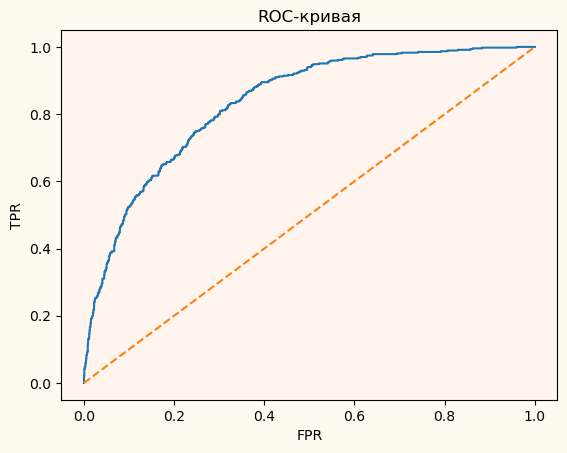

In [122]:
fig, ax = plt.subplots()

fpr, tpr, thresholds = roc_curve(target_test, y_pred_probs_test)

ax.plot(fpr, tpr)
ax.plot([0, 1], [0, 1], linestyle='--')

ax.set(xlabel = 'FPR',
       ylabel = 'TPR',
       title = 'ROC-кривая')

fig.set_facecolor('floralwhite')
ax.set_facecolor('seashell')

plt.show()

По графику можно судить, что модель прошла тест на адекватность.

Выведем матрицу ошибок:

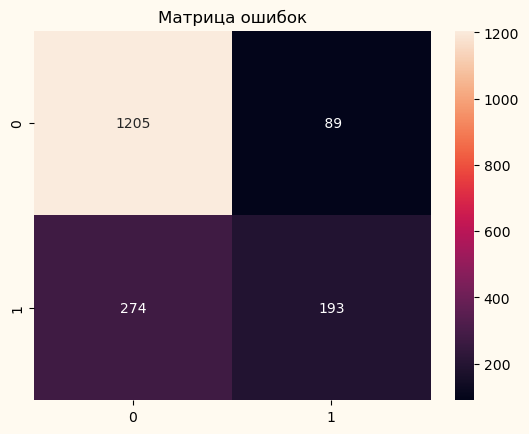

In [123]:
fig, ax = plt.subplots()

sns.heatmap(confusion_matrix(target_test, y_pred_probs),annot=True,fmt='3.0f')

fig.set_facecolor('floralwhite')
ax.set_facecolor('seashell')
ax.set(title='Матрица ошибок')

plt.show()

Дадим комментарии:

- 1144 -- число клиентов, которые были корректно идентифицированы моделью как те, что не разорвут контракт.

- 207 -- число клиентов, которые были корректно идентифицированы моделью как те, что точно разорвут контракт.

- 150 -- число клиентов, которые были НЕ корректно идентифицированы моделью как те, что точно разорвут контракт.

- 260 -- число клиентов, которые были НЕ корректно идентифицированы моделью как те, что не разорвут контракт.

## Дополнительно: оценка качества с константной моделью

Дополнительно сравним качество итоговой модели с константной моделью

In [124]:
model_const = DummyClassifier(strategy='constant', constant=1, random_state=random_state)
model_const.fit(features_train, target_train)
predict_test = model_const.predict(features_test)
roc_auc_const = roc_auc_score(target_test, predict_test)
print('ROC-AUC const model = ', roc_auc_const)
print('ROC-AUC neural model = ', roc_auc_test)
print('Dependence ROC-AUC = ', roc_auc_test - roc_auc_const)

ROC-AUC const model =  0.5
ROC-AUC neural model =  0.8345609285484976
Dependence ROC-AUC =  0.3345609285484976


Разница между константной моделью и нейросетью `0.33`

# Анализ важности признаков

Проанализируем важность входных признаков, влияющих на отток клиентов. Используем Shap. Ниже представлена диаграмма. Признаки идут сверху вниз по убыванию влияния на целевой. Например, признак Type оказывает наибольшее влияние.

Значения слева от центральной вертикальной линии отвечают тем, кто не разорвёт контракт, справа -- тем, кто с высокой долей вероятности уйдёт. Чем более красная точка, тем больше соответствующее наблюдаемое значение. Чем более синяя, тем меньше соответствующее наблюдаемое значение. Чем толще линия, тем больше зафиксировано наблюдений.

Например, линия для TotalCharges говорит о том, что чем меньше суммарные расходы в год, тем с большей вероятностью клиент уйдёт: справа только синий цвет. Много красных точек справа говорит о том, что клиент останется, если расходы очень большие. Меньше всего точек у признака gender: он практически не влияет на целевой.

In [125]:
import logging
logger = logging.getLogger()
logger.setLevel(logging.CRITICAL)

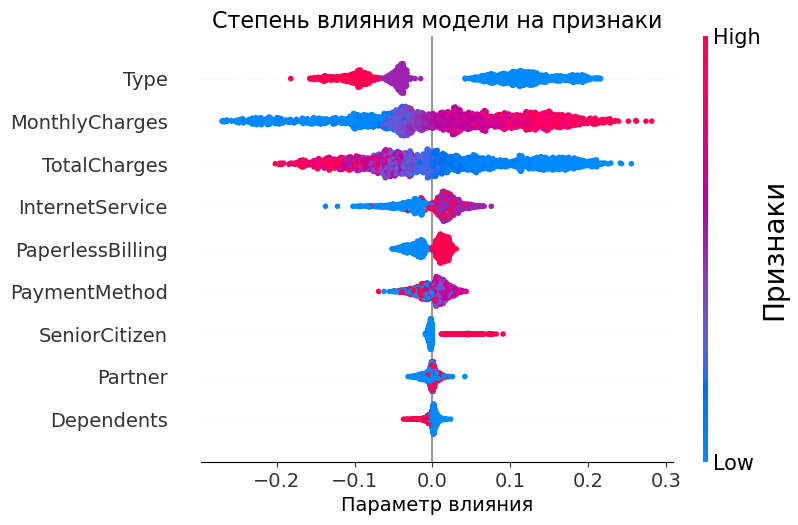

In [126]:
X_test_numpy = X_test.numpy()

def predict_fn(x):
    best_net.eval()
    with torch.no_grad():
        x_tensor = torch.FloatTensor(x) 
        output = best_net(x_tensor)
        return torch.sigmoid(output).numpy()

feature_names = features_test.columns.tolist()

explainer = shap.explainers.Permutation(predict_fn, feature_names=feature_names, masker=shap.maskers.Independent(data=X_test_numpy), silent=True)

shap_values = explainer.shap_values(X_test_numpy)

shap.summary_plot(shap_values, X_test_numpy, feature_names=feature_names, show=False)


fig, ax = plt.gcf(), plt.gca()

# Modifying main plot parameters
ax.tick_params(labelsize=14)
ax.set_xlabel("Параметр влияния", fontsize=14)
ax.set_title('Степень влияния модели на признаки', fontsize=16)

# Get colorbar
cb_ax = fig.axes[1]

# Modifying color bar parameters
cb_ax.tick_params(labelsize=15)
cb_ax.set_ylabel("Признаки", fontsize=20)

plt.show()

Покажем зависимость между одним из важных признаков, который оказывает на модель – `Type` и целевой признак – `target`

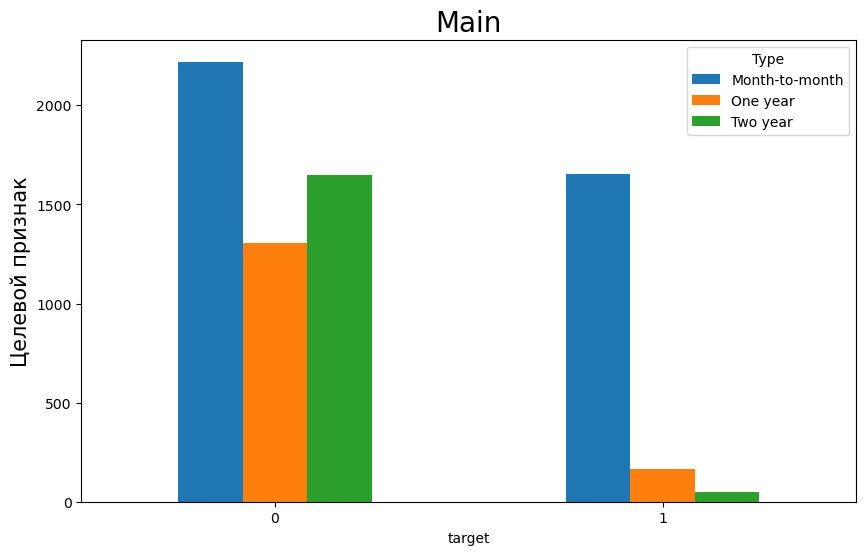

[CV 2/3] END boosting_type=dart, max_depth=1, n_estimators=30;, score=0.808 total time=   0.0s
[CV 3/3] END boosting_type=dart, max_depth=1, n_estimators=30;, score=0.798 total time=   0.0s
[CV 1/3] END boosting_type=dart, max_depth=2, n_estimators=1;, score=0.777 total time=   0.0s
[CV 2/3] END boosting_type=dart, max_depth=2, n_estimators=1;, score=0.799 total time=   0.0s
[CV 3/3] END boosting_type=dart, max_depth=2, n_estimators=1;, score=0.775 total time=   0.0s
[CV 1/3] END boosting_type=dart, max_depth=2, n_estimators=2;, score=0.784 total time=   0.0s
[CV 1/3] END boosting_type=dart, max_depth=3, n_estimators=15;, score=0.830 total time=   0.0s
[CV 2/3] END boosting_type=dart, max_depth=3, n_estimators=15;, score=0.843 total time=   0.0s
[CV 3/3] END boosting_type=dart, max_depth=3, n_estimators=15;, score=0.825 total time=   0.0s
[CV 1/3] END boosting_type=dart, max_depth=3, n_estimators=16;, score=0.830 total time=   0.0s
[CV 2/3] END boosting_type=dart, max_depth=3, n_estima

[CV 1/3] END boosting_type=dart, max_depth=3, n_estimators=2;, score=0.807 total time=   0.0s
[CV 2/3] END boosting_type=dart, max_depth=3, n_estimators=2;, score=0.822 total time=   0.0s
[CV 3/3] END boosting_type=dart, max_depth=3, n_estimators=2;, score=0.809 total time=   0.0s
[CV 1/3] END boosting_type=dart, max_depth=3, n_estimators=3;, score=0.808 total time=   0.0s
[CV 2/3] END boosting_type=dart, max_depth=3, n_estimators=3;, score=0.838 total time=   0.0s
[CV 3/3] END boosting_type=dart, max_depth=3, n_estimators=3;, score=0.811 total time=   0.0s
[CV 1/3] END boosting_type=dart, max_depth=3, n_estimators=4;, score=0.818 total time=   0.0s
[CV 1/3] END boosting_type=dart, max_depth=4, n_estimators=1;, score=0.824 total time=   0.0s
[CV 2/3] END boosting_type=dart, max_depth=4, n_estimators=1;, score=0.837 total time=   0.0s
[CV 3/3] END boosting_type=dart, max_depth=4, n_estimators=1;, score=0.819 total time=   0.0s
[CV 1/3] END boosting_type=dart, max_depth=4, n_estimators=2

[CV 2/3] END boosting_type=dart, max_depth=2, n_estimators=28;, score=0.840 total time=   0.0s
[CV 3/3] END boosting_type=dart, max_depth=2, n_estimators=28;, score=0.811 total time=   0.0s
[CV 2/3] END boosting_type=dart, max_depth=4, n_estimators=22;, score=0.852 total time=   0.0s
[CV 3/3] END boosting_type=dart, max_depth=4, n_estimators=22;, score=0.833 total time=   0.0s
[CV 1/3] END boosting_type=dart, max_depth=4, n_estimators=23;, score=0.833 total time=   0.0s
[CV 2/3] END boosting_type=dart, max_depth=4, n_estimators=23;, score=0.852 total time=   0.0s
[CV 3/3] END boosting_type=dart, max_depth=4, n_estimators=23;, score=0.833 total time=   0.0s
[CV 1/3] END boosting_type=dart, max_depth=4, n_estimators=24;, score=0.833 total time=   0.0s
[CV 2/3] END boosting_type=dart, max_depth=4, n_estimators=24;, score=0.852 total time=   0.0s
[CV 3/3] END boosting_type=dart, max_depth=4, n_estimators=24;, score=0.833 total time=   0.0s
[CV 1/3] END boosting_type=dart, max_depth=4, n_es

[CV 2/3] END boosting_type=dart, max_depth=4, n_estimators=16;, score=0.851 total time=   0.0s
[CV 3/3] END boosting_type=dart, max_depth=4, n_estimators=16;, score=0.832 total time=   0.0s
[CV 3/3] END boosting_type=dart, max_depth=5, n_estimators=13;, score=0.834 total time=   0.0s
[CV 1/3] END boosting_type=dart, max_depth=5, n_estimators=14;, score=0.833 total time=   0.0s
[CV 2/3] END boosting_type=dart, max_depth=5, n_estimators=14;, score=0.851 total time=   0.0s
[CV 3/3] END boosting_type=dart, max_depth=5, n_estimators=14;, score=0.834 total time=   0.0s
[CV 1/3] END boosting_type=dart, max_depth=5, n_estimators=15;, score=0.834 total time=   0.0s
[CV 2/3] END boosting_type=dart, max_depth=5, n_estimators=15;, score=0.852 total time=   0.0s
[CV 3/3] END boosting_type=dart, max_depth=5, n_estimators=15;, score=0.834 total time=   0.0s
[CV 1/3] END boosting_type=dart, max_depth=5, n_estimators=16;, score=0.834 total time=   0.0s
[CV 2/3] END boosting_type=dart, max_depth=5, n_es

[CV 3/3] END boosting_type=dart, max_depth=3, n_estimators=28;, score=0.832 total time=   0.0s
[CV 1/3] END boosting_type=dart, max_depth=3, n_estimators=29;, score=0.833 total time=   0.0s
[CV 2/3] END boosting_type=dart, max_depth=3, n_estimators=29;, score=0.849 total time=   0.0s
[CV 3/3] END boosting_type=dart, max_depth=3, n_estimators=29;, score=0.832 total time=   0.0s
[CV 1/3] END boosting_type=dart, max_depth=3, n_estimators=30;, score=0.833 total time=   0.0s
[CV 2/3] END boosting_type=dart, max_depth=3, n_estimators=30;, score=0.848 total time=   0.0s
[CV 3/3] END boosting_type=dart, max_depth=3, n_estimators=30;, score=0.831 total time=   0.0s
[CV 1/3] END boosting_type=dart, max_depth=5, n_estimators=19;, score=0.834 total time=   0.0s
[CV 2/3] END boosting_type=dart, max_depth=5, n_estimators=19;, score=0.852 total time=   0.0s
[CV 3/3] END boosting_type=dart, max_depth=5, n_estimators=19;, score=0.834 total time=   0.0s
[CV 1/3] END boosting_type=dart, max_depth=5, n_es

[CV 3/3] END boosting_type=dart, max_depth=1, n_estimators=1;, score=0.723 total time=   0.0s
[CV 1/3] END boosting_type=dart, max_depth=1, n_estimators=2;, score=0.729 total time=   0.0s
[CV 2/3] END boosting_type=dart, max_depth=1, n_estimators=2;, score=0.738 total time=   0.0s
[CV 3/3] END boosting_type=dart, max_depth=1, n_estimators=2;, score=0.723 total time=   0.0s
[CV 1/3] END boosting_type=dart, max_depth=1, n_estimators=3;, score=0.729 total time=   0.0s
[CV 2/3] END boosting_type=dart, max_depth=1, n_estimators=3;, score=0.738 total time=   0.0s
[CV 3/3] END boosting_type=dart, max_depth=1, n_estimators=3;, score=0.723 total time=   0.0s
[CV 1/3] END boosting_type=dart, max_depth=1, n_estimators=4;, score=0.729 total time=   0.0s
[CV 2/3] END boosting_type=dart, max_depth=1, n_estimators=4;, score=0.738 total time=   0.0s
[CV 3/3] END boosting_type=dart, max_depth=1, n_estimators=4;, score=0.723 total time=   0.0s
[CV 1/3] END boosting_type=dart, max_depth=1, n_estimators=5

In [127]:
df_depend = pd.crosstab(index=df['target'],columns=df['Type'])
df_depend.plot.bar(figsize=(10,6), rot=0)

plt.title('Main', fontsize=20)
plt.ylabel("Количество", fontsize=15)
plt.ylabel("Целевой признак", fontsize=15)
plt.show()

# Выводы

Наилучший результат показала модель полносвязной нейронной сети с 1 скрытым слоем и 70 нейронами на 100 эпохах. Модель немного чаще идентифицирует клиентов, которые склонны к разрыву контракта, как тех, кто не совершит этого.

Корреляционное исследование показывает, что наибольшее влияние на целевой признак оказывают месячные и годовые траты пользователей. Чаще остаются те, кто сразу оплачивает год или два. Гораздо чаще уходят те, кто платит только за месяц Это может свидетельствовать о том, что пакет для "премиум" клиентов (платят сразу и много) сильно отличается от того, что доступен клиентам с базовой подпиской. Имеет смысл посмотреть, как можно доработать месячный пакет, чтобы удерживать и таких клиентов. Косвенно эту гипотезу подтверждает то, что реже всего отказываются клиенты, у которых подключено много дополнительных пакетов услуг: похоже, что они все автоматически включаются в годовую подписку.

Кроме того, большой процент отказников наблюдается среди тех, кто пользуется оптоволоконным интернетом. Имеет смысл запустить диагностику его качества.